# **PORTFOLIO OPTIMISATION 2019**

In [1]:
import numpy as np
import pandas as pd
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import investpy as ipy
%matplotlib inline
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from statsmodels import regression
from sklearn.linear_model import LinearRegression
#from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
today = dt.datetime.today().strftime("%d/%m/%Y")
import mlportfolio

In [2]:
#pd.set_option('display.max_rows', 100)
#plt.rcParams['axes.xmargin'] = 0
scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [3]:
def log_rate(df):
    return np.log(df / df.shift(1)).dropna(how='all')

def ewcorr(df, span=300):
    corr = df.ewm(span=span).corr()
    return corr.loc[corr.index.levels[0][-1]]

def ewcov(df, span=300):
    cov = df.ewm(span=span).cov()
    return cov.loc[cov.index.levels[0][-1]]

def ewstd(df, span=300):
    std = df.ewm(span=span).std()
    return std.iloc[-1]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

def getPCA(df):
    pca = PCA(n_components=2)

    pComponents = pca.fit_transform(df)

    df_PCA = pd.DataFrame(data = pComponents, index=df.index,
                          columns = ['Principal Component 1', 'Principal Component 2'])
    return df_PCA

In [4]:
plt.style.use(['seaborn'])

In [5]:
pd.set_option("display.max_rows", 20)
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Lists of Stocks 

Here, the most up-to-date list of Kompas 100 stocks is collected from Kontan. Kompas 100 was chosen as the stocks universe as it provides a larger dataset than LQ45 or IDX30 yet manageable enough for the computational  resource available for the research in comparison to the 600+ of stocks listed on IDX.

In [6]:
# lis = mlportfolio.index_list_kontan('KOMPAS100')
# df = lis.download()
# df.to_pickle('stocks-list.pkl')

In [7]:
df = pd.read_pickle('stocks-list.pkl')
code = df['Kode']
code_arr =[]
sym = []
for i in range(len(code)):
  sym.append(code[i])
  code_arr.append(code[i]+'.JK')

## **Data Reader**

After the list of stocks has been collected, using `yfinance` module to download the historical time series data from Yahoo Finance. The data collected for these stocks span from 1 Jan 2010 to today.

### **KOMPAS100 Stocks Prices: 2010-2021**

In [8]:
training_year ='2018'
test_year = '2019'

In [9]:
# # df1 = yf.download(code_arr, start='2010-01-01')
# # df1.info()
# df1.to_pickle('stocks-data.pkl')

In [10]:
df0 = pd.read_pickle('stocks-data.pkl')

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2010-01-04 to 2021-12-13
Columns: 600 entries, ('Adj Close', 'AALI.JK') to ('Volume', 'WTON.JK')
dtypes: float64(600)
memory usage: 13.5 MB


In [12]:
data_count = df0['Adj Close'].describe().loc['count']

In [13]:
thresh=data_count.median()

<AxesSubplot:>

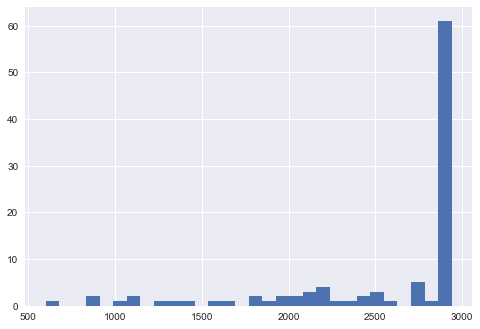

In [14]:
data_count.hist(bins=30)

In [15]:
df1 = df0.dropna(axis=1, thresh=thresh)

<AxesSubplot:xlabel='Date'>

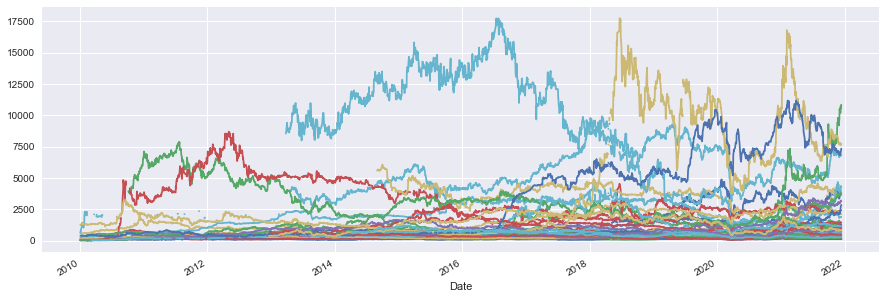

In [372]:
df0['Adj Close'].drop(df1['Adj Close'].columns, axis = 1).plot(legend=False, figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Adj Close Price'>

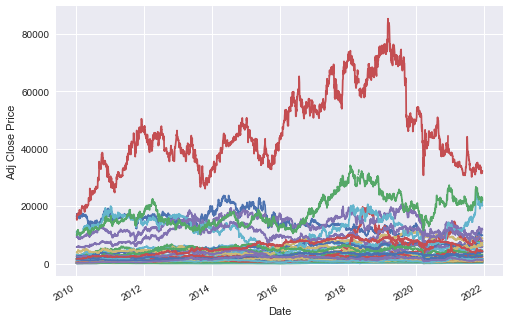

In [16]:
df1['Adj Close'].plot(legend=False, xlabel='Date', ylabel='Adj Close Price' )

In [17]:
adj_close = df1['Adj Close']

In [18]:
columns=df1.columns.get_level_values(0).unique()

In [19]:
df1.groupby(level=0, axis=1).mean().describe().round(2)

,Adj Close,Close,High,Low,Open,Volume
count,2945.00,2945.00,2945.00,2945.00,2945.00,2.945000e+03
mean,4051.23,4929.55,5001.18,4859.64,4932.98,3.067864e+07
std,759.20,685.55,687.48,682.76,685.68,1.565195e+07
min,1312.52,1335.00,1335.00,1335.00,1335.00,0.000000e+00
25%,3546.16,4500.06,4580.42,4431.99,4502.73,2.195886e+07
50%,4009.96,4977.58,5052.96,4913.75,4983.60,2.730578e+07
75%,4496.56,5359.39,5420.95,5282.19,5355.99,3.493761e+07
max,6117.38,6838.59,6838.59,6838.59,6838.59,1.878984e+08


In [20]:
df1.groupby(level=0, axis=1).mean().round(2)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,2219.25,3394.89,3427.35,3313.44,3359.85,17055766.65
2010-01-05,2248.67,3448.27,3473.45,3385.44,3446.54,29412161.88
2010-01-06,2245.34,3441.43,3507.69,3405.32,3438.84,31741730.48
2010-01-07,2248.64,3441.88,3499.48,3386.57,3439.67,33546109.37
2010-01-08,2284.49,3492.09,3518.48,3427.29,3492.33,23862044.17
...,...,...,...,...,...,...
2021-12-07,4366.52,4366.52,4410.96,4317.00,4360.44,29842071.15
2021-12-08,4325.35,4325.35,4408.77,4306.40,4374.88,29492005.77
2021-12-09,4340.31,4340.31,4386.10,4301.19,4339.77,24417751.92


In [21]:
adj_close

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16410.125000,270.381287,1063.347290,754.387878,1601.085449,2518.653564,96.725533,855.341125,588.306885,655.905151,...,1855.615967,116.141266,448.737213,5704.010254,259.101562,1120.500000,1403.605713,9867.144531,1649.384644,247.194794
2010-01-05,16650.947266,263.786591,1087.652222,742.020874,1601.085449,2532.923584,98.567917,863.809998,592.078125,655.905151,...,1855.615967,118.374763,482.732574,5779.062988,263.647217,1146.864624,1410.954590,10118.534180,1701.627808,247.194794
2010-01-06,16582.144531,267.083893,1093.728638,735.837280,1601.085449,2518.653564,98.567917,838.403809,584.535706,726.180725,...,1897.314941,111.674309,469.134491,5854.115723,268.192841,1160.047241,1396.257080,10087.111328,1686.700806,247.194794
2010-01-07,17235.794922,270.381287,1118.033569,723.470398,1635.891724,2440.168457,99.489105,842.638184,576.993347,726.180725,...,1902.527344,110.557556,455.536346,5779.062988,268.192841,1146.864624,1359.513550,9961.415039,1656.848022,247.194794
2010-01-08,17373.404297,273.678589,1190.949097,717.286987,1635.891724,2454.438232,102.252693,821.466431,580.764526,749.605896,...,1907.739746,111.674309,448.737213,5741.537109,268.192841,1146.864624,1374.210938,10307.079102,1664.311157,243.449371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07,9925.000000,1090.000000,1905.000000,4260.000000,2340.000000,5925.000000,171.000000,7350.000000,4230.000000,1750.000000,...,2750.000000,486.000000,695.000000,8075.000000,880.000000,1550.000000,4150.000000,23000.000000,4270.000000,1215.000000
2021-12-08,9925.000000,1085.000000,1925.000000,4290.000000,2330.000000,5800.000000,171.000000,7425.000000,4210.000000,1750.000000,...,2720.000000,488.000000,695.000000,8025.000000,875.000000,1540.000000,4090.000000,22350.000000,4270.000000,1205.000000
2021-12-09,9950.000000,1075.000000,1935.000000,4330.000000,2330.000000,6000.000000,172.000000,7350.000000,4190.000000,1750.000000,...,2720.000000,480.000000,690.000000,8025.000000,880.000000,1565.000000,4150.000000,22325.000000,4370.000000,1190.000000


In [22]:
stocks_list = adj_close.columns

### **KOMPAS 100 Index Prices: 2010-2021**

In [23]:
# df2 = ipy.indices.get_index_historical_data(index='idx kompas 100', country='Indonesia', from_date='01/01/2010', to_date= today)
# df2.info()
# df2.to_pickle('market-data.pkl')

In [24]:
df2 = pd.read_pickle('market-data.pkl')
df2.describe().round(2)

,Open,High,Low,Close,Volume
count,2926.00,2926.00,2926.00,2926.00,2.926000e+03
mean,1052.30,1058.85,1044.65,1051.93,3.858968e+09
std,172.92,172.46,172.77,172.28,3.313029e+10
min,591.86,595.92,580.38,592.09,0.000000e+00
25%,922.67,929.16,914.17,923.21,2.256659e+09
50%,1069.06,1075.26,1061.62,1068.62,2.897808e+09
75%,1193.59,1200.60,1187.73,1193.44,3.788222e+09
max,1420.94,1421.95,1406.81,1421.50,1.793415e+12


In [25]:
df2.head(10)
market_data_all = df2

<AxesSubplot:xlabel='Date'>

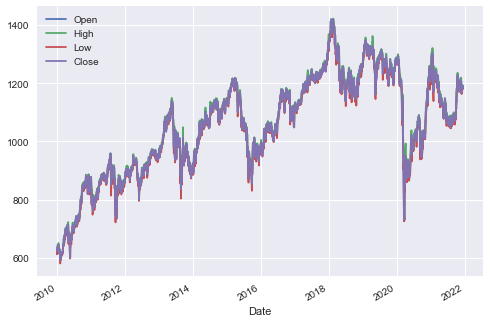

In [26]:
df2.iloc[:, :4].plot()

### **Indonesia Gov't Bond Yield 1 Year: 2010-2021**

Here, the bond yields of Indonesia's 1 Year Bond from 1 Jan 2010 to today are collected from Investing.com. 

In [27]:
# df5 = ipy.bonds.get_bond_historical_data(bond = 'INDONESIA 1Y', from_date='01/01/2010', to_date= today)
# bond_yield = df5[df5.index.isin(df2.index)].divide(100)
# bond_yield.to_pickle('bond-data.pkl')

<AxesSubplot:xlabel='Date', ylabel='Rate'>

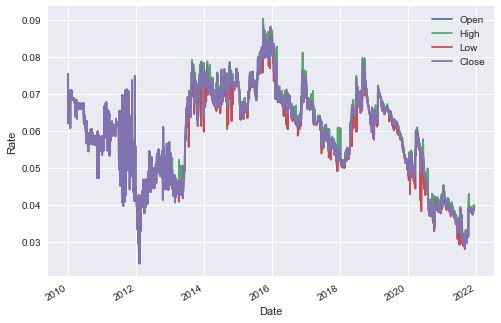

In [28]:
bond_yield = pd.read_pickle('bond-data.pkl').replace(0, method='ffill')
bond_yield.plot(ylabel='Rate')

In [29]:
bond_yield.describe().round(3)

,Open,High,Low,Close
count,2909.000,2909.000,2909.000,2909.000
mean,0.059,0.060,0.059,0.059
std,0.013,0.013,0.012,0.013
min,0.024,0.024,0.024,0.024
25%,0.050,0.051,0.050,0.050
50%,0.062,0.062,0.062,0.062
75%,0.068,0.069,0.068,0.068
max,0.090,0.090,0.089,0.089


### **Financial Summaries of KOMPAS100 Companies**

In [30]:
# info_summ = pd.DataFrame()
# fin_dict = {}

# for x in sym: 
#     info = ipy.stocks.get_stock_information(stock= x, country= 'Indonesia')
#     info_summ = info_summ.append(info)
    
#     try:
#         inc_sta = ipy.stocks.get_stock_financial_summary(stock= x, country= 'Indonesia', summary_type='income_statement')
#         fin_dict[x +'.JK']= inc_sta.sort_values(by='Date')
#     except:
#         pass

In [31]:
# fin_summ = pd.concat(fin_dict, axis=1)*1000000 #Values should be in millions IDR

# info_summ.reset_index(drop=True)
# info_summ.index = code_arr

In [32]:
# fin_summ.to_pickle('fin-summ.pkl')
# info_summ.to_pickle('info-summ.pkl')

In [33]:
info_summ = pd.read_pickle('info-summ.pkl').loc[stocks_list]
info_summ

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date
AALI.JK,AALI,8575.0,"8,475-8,600",2.056000e+13,8600.0,"7,275-13,350",566.60,645100.0,1.636000e+13,153.00(1.80%),1822292.0,15.0,1.6,-13.49%,1.924688e+09,01/11/2021
ADHI.JK,ADHI,815.0,810-830,1.527000e+13,815.0,"488-2,040",5.89,15876400.0,2.920000e+12,N/A(N/A),20883567.0,139.13,2.94,50.46%,3.560849e+09,01/11/2021
ADRO.JK,ADRO,1365.0,"1,345-1,375",3.943000e+13,1370.0,"1,090-1,600",69.83,61919000.0,4.318000e+13,65.41(4.91%),83198919.0,19.33,1.17,20.54%,3.198596e+10,02/11/2021
AKRA.JK,AKRA,3770.0,"3,730-3,770",1.648000e+13,3770.0,"2,450-3,960",264.42,1881200.0,1.476000e+13,135.00(3.58%),8070630.0,14.14,1.8,41.67%,3.947434e+09,01/11/2021
ANTM.JK,ANTM,2440.0,"2,470-2,630",3.138000e+13,2470.0,"695-3,440",85.79,423200100.0,6.224000e+13,16.74(0.65%),101072438.0,30.19,2.4,250%,2.403076e+10,22/10/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,TINS,1500.0,"1,515-1,570",1.311000e+13,1520.0,"655-2,540",43.64,98472400.0,1.143000e+13,N/A(N/A),35982937.0,35.17,2.57,104.67%,7.447753e+09,09/11/2021
TLKM.JK,TLKM,3390.0,"3,320-3,390",1.390900e+14,3380.0,"2,540-3,640",224.77,52115300.0,3.298800e+14,168.01(4.96%),87192791.0,14.82,0.79,23.33%,9.906222e+10,25/10/2021
UNTR.JK,UNTR,21800.0,"21,150-21,700",6.447000e+13,21700.0,"18,525-28,475",1731.29,2663900.0,7.917000e+13,473.00(3.03%),3613248.0,12.26,0.72,-0.82%,3.730135e+09,01/11/2021
UNVR.JK,UNVR,4100.0,"4,080-4,150",4.138000e+13,4130.0,"4,010-8,325",172.73,14311100.0,1.556500e+14,187.00(4.56%),23514959.0,23.62,0.4,-48.84%,3.815000e+10,26/10/2021


In [34]:
fin_summ = pd.read_pickle('fin-summ.pkl').loc[:,stocks_list]
fin_test=fin_summ[:training_year]

In [35]:
fin_test

AALI.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  1.730569e+13  4.145250e+12     2.992440e+12  1.968027e+12   
2018-12-31  1.908439e+13  3.539506e+12     2.180324e+12  1.438511e+12   

                 ADHI.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  1.515618e+13  2.057806e+12     1.707672e+12  5.154153e+11   
2018-12-31  1.565550e+13  2.506603e+12     1.798931e+12  6.441589e+11   

                 ADRO.JK                ...          UNTR.JK                \
           Total Revenue  Gross Profit  ... Operating Income    Net Income   
Date                                    ...                                  
2017-12-31  3.258330e+09  1.141500e+09  ...     1.057159e+13  7.402966e+12   
2018-12-31  3.619750e+09  1.210210e+09  ...     1.658316e+13  1.112563e+13   

                 UNVR.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  4.120451e+13  2.123528e+13     9.495764e+12  7.004562e+12   
2018-12-31  4.180207e+13  2.116389e+13     1.232421e+13  9.081187e+12   

                 WIKA.JK                                               
           Total Revenue  Gross Profit Operating Income    Net Income  
Date                                                                   
2017-12-31  2.617640e+13  2.876234e+12     2.804569e+12  1.202069e+12  
2018-12-31  3.115819e+13  3.604727e+12     4.367729e+12  1.730256e+12  

[2 rows x 195 columns]

In [36]:
avg_growth = fin_test.pct_change().dropna().mean().rename(index={'Total Revenue': 'Mean Revenue Growth', 'Gross Profit':'Mean Gross Profit Growth',
                                                                'Net Income': 'Mean Net Income Growth', 'Operating Income': 'Mean Operating Income Growth'})

growth_dict={'Mean Rev. Growth': avg_growth[:,'Mean Revenue Growth'],
             'Mean Net Inc. Growth': avg_growth[:,'Mean Net Income Growth']}

In [37]:
growth_data = pd.concat(growth_dict, axis=1)
growth_data[(growth_data.isnull()).any(axis=1)]

,Mean Rev. Growth,Mean Net Inc. Growth


In [38]:
index_=adj_close.columns
eps = info_summ['EPS'][index_]
per = pd.to_numeric(info_summ['P/E Ratio'], errors='coerce').fillna(0)[index_]
mcap = pd.to_numeric(info_summ['Market Cap'], errors='coerce')[index_].round(2)
beta_real = pd.to_numeric(info_summ['Beta'], errors='coerce')[index_]

## **Daily Returns of Stocks**

In [39]:
close_price_all = adj_close.interpolate(method='time', axis=0)#.dropna(axis=0, how='all').round(2)
close_price_all[(close_price_all==0).any(axis=1)]

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,


In [40]:
close_price = close_price_all[:training_year]

In [41]:
ret_all = log_rate(close_price)#close_price.apply(lambda x: np.log(1+x)).pct_change().dropna(how='all')

In [42]:
ret_all

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014569,-0.024693,0.022600,-0.016529,0.000000,0.005650,0.018868,0.009852,0.006390,0.000000,...,0.000000,0.019048,0.073025,0.013072,0.017392,0.023257,0.005222,0.025158,0.031183,0.000000
2010-01-06,-0.004141,0.012422,0.005571,-0.008368,0.000000,-0.005650,0.000000,-0.029853,-0.012821,0.101783,...,0.022223,-0.058269,-0.028573,0.012903,0.017094,0.011429,-0.010471,-0.003110,-0.008811,0.000000
2010-01-07,0.038662,0.012270,0.021979,-0.016949,0.021506,-0.031657,0.009302,0.005038,-0.012987,0.000000,...,0.002743,-0.010050,-0.029414,-0.012903,0.000000,-0.011429,-0.026668,-0.012539,-0.017857,0.000000
2010-01-08,0.007952,0.012121,0.063179,-0.008584,0.000000,0.005831,0.027399,-0.025447,0.006515,0.031749,...,0.002736,0.010050,-0.015038,-0.006515,0.000000,0.000000,0.010753,0.034112,0.004494,-0.015268
2010-01-11,-0.011952,-0.012121,0.010152,0.017094,-0.010695,0.015862,0.052644,0.010256,0.000000,-0.021054,...,-0.010989,0.000000,-0.030772,0.012987,0.000000,0.011429,0.010638,0.050531,0.008929,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007576,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,-0.053401,-0.028348,-0.024293,-0.011615,0.000000,-0.036258,-0.005083,0.010582,-0.005540,-0.015625,...,0.014085,-0.016807,0.000000,0.004338,-0.062914,-0.027029,-0.008011,-0.029040,-0.023339,-0.017596
2018-12-27,-0.010605,0.003190,0.016260,0.016223,0.000000,0.012233,-0.006390,-0.005758,0.016529,0.011742,...,0.000000,0.025106,-0.014085,0.010764,0.025642,0.020340,0.005348,0.016439,0.023339,-0.011905


### **Daily Average Rate of Return**

<AxesSubplot:xlabel='Date', ylabel='Daily Returns'>

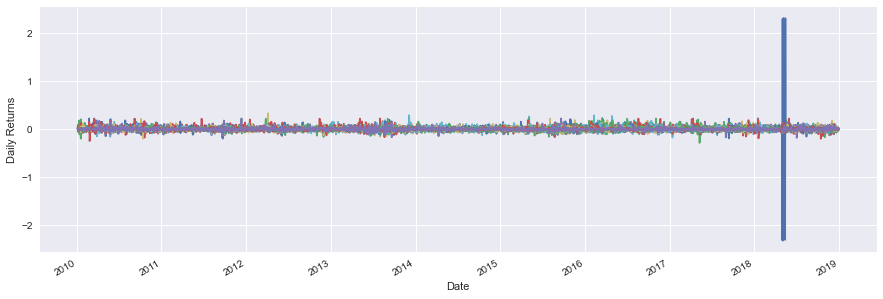

In [43]:
ret_all.plot(legend=False, ylabel='Daily Returns', figsize=(15,5))

In [44]:
ret_all.max().sort_values()

ICBP.JK    0.092659
INDF.JK    0.098671
JSMR.JK    0.103184
ASII.JK    0.106972
BBCA.JK    0.109199
             ...   
GJTL.JK    0.223144
PGAS.JK    0.227390
DOID.JK    0.292136
BDMN.JK    0.330242
MAPI.JK    2.308777
Length: 52, dtype: float64

In [45]:
# ret_all.info()

### **Daily Price Movements**

In [46]:
open_price = df1['Open'][:training_year].dropna(how='all')
close_price = df1['Close'][:training_year].dropna(how='all')

In [47]:
daily_movt = log_rate(close_price/open_price).fillna(0)

In [48]:
daily_movt_corr=daily_movt.ewm(span=300).mean().corr()

In [49]:
daily_movt_dist=np.sqrt((1-daily_movt_corr)*2.0)

## **Volume**

In [50]:
stocks_volume = df1['Volume'][:training_year].dropna(how='all', axis=1)
stocks_volume_d_avg=stocks_volume.mean()
stocks_volume_total = stocks_volume.sum()

<AxesSubplot:xlabel='Date'>

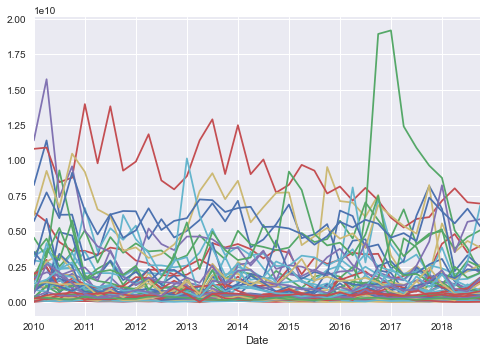

In [51]:
stocks_volume.resample('BQ').sum().plot(legend=False)

In [52]:
market_volume =  df2['Volume'][:training_year]
market_volume_d_avg=market_volume.mean()
market_volume_total = market_volume.sum()

In [53]:
avg_daily_volume_ratio = stocks_volume_d_avg / market_volume_d_avg
avg_daily_volume_ratio.sort_values()

GGRM.JK    0.000270
AALI.JK    0.000372
ISAT.JK    0.000391
ITMG.JK    0.000402
INTP.JK    0.000708
             ...   
BBCA.JK    0.018132
ASRI.JK    0.019156
LPKR.JK    0.024067
TLKM.JK    0.024621
BBRI.JK    0.037936
Length: 52, dtype: float64

In [54]:
total_volume_ratio = stocks_volume_total / market_volume_total
total_volume_ratio.sort_values()

GGRM.JK    0.000271
AALI.JK    0.000373
ISAT.JK    0.000392
ITMG.JK    0.000403
INTP.JK    0.000708
             ...   
BBCA.JK    0.018165
ASRI.JK    0.019130
LPKR.JK    0.024067
TLKM.JK    0.024632
BBRI.JK    0.037970
Length: 52, dtype: float64

In [55]:
volume_data = pd.DataFrame({'Total Vol. Ratio':total_volume_ratio, 
                            'Avg. Trading Vol. Ratio (Daily)':avg_daily_volume_ratio})
volume_data.sort_values(by='Total Vol. Ratio')

,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily)
GGRM.JK,0.000271,0.000270
AALI.JK,0.000373,0.000372
ISAT.JK,0.000392,0.000391
ITMG.JK,0.000403,0.000402
INTP.JK,0.000708,0.000708
...,...,...
BBCA.JK,0.018165,0.018132
ASRI.JK,0.019130,0.019156
LPKR.JK,0.024067,0.024067
TLKM.JK,0.024632,0.024621


In [56]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

# data_plot=volume_data

# fig, ax = plt.subplots(figsize = [10,8])
# ax = sns.scatterplot(x='Total Vol. Ratio', y='Avg. Trading Vol. Ratio (Daily)', 
#                 data=data_plot, s=100)
# ax.set_title('Trade Volume of Stocks vs Market Volume', fontsize=20)
# label_point(data_plot['Total Vol. Ratio'], data_plot['Avg. Trading Vol. Ratio (Daily)'],
#             data_plot.index.to_series(), ax)

### **Data Clean Up**

Here we can see that there are definite outliers in the data. To clean up the data, we caculate the _Z-score_ of each stock (column) and remove any value that has a _Z-score_ of above $\pm 3\sigma$.

In [57]:
from scipy import stats

In [58]:
ret = ret_all.apply(lambda col: col[np.abs(stats.zscore(col, nan_policy='omit')) < 3])
ret = ret.interpolate(method='time')

<AxesSubplot:xlabel='Date', ylabel='Daily Returns'>

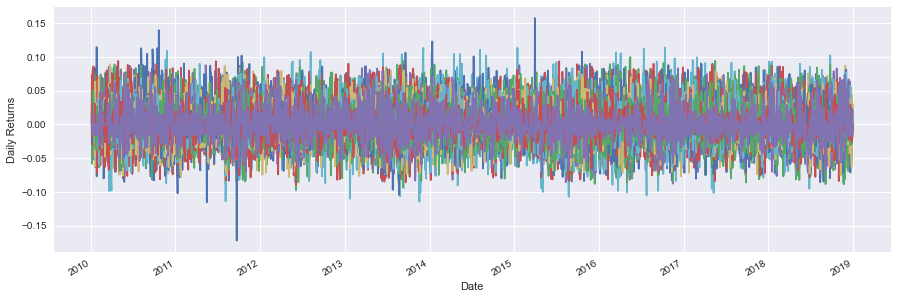

In [59]:
ret.plot(legend=False, ylabel='Daily Returns', figsize=(15,5))

In [60]:
ret_ann = ret.resample('Y').sum()
ret_ann.index = ret_ann.index.strftime('%Y')

In [61]:
ret_mon = ret.resample('BM').sum()

In [62]:
sample=ret.sample(n=5, axis=1).columns

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

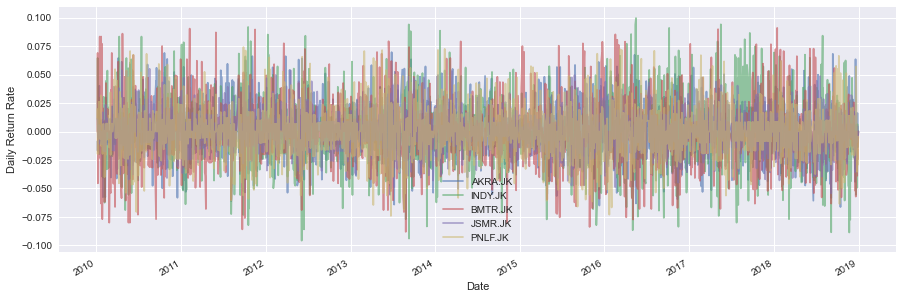

In [63]:
ret[sample].plot(ylabel='Daily Return Rate', alpha=0.6, figsize=(15,5))

In [64]:
ret[sample]

,AKRA.JK,INDY.JK,BMTR.JK,JSMR.JK,PNLF.JK
Date,,,,,
2010-01-05,-0.016529,0.011173,0.000000,0.010753,0.019803
2010-01-06,-0.008368,0.064538,0.068993,0.005333,-0.019803
2010-01-07,-0.016949,0.030772,-0.045462,-0.005333,0.000000
2010-01-08,-0.008584,0.000000,0.000000,-0.005362,0.000000
2010-01-11,0.017094,0.029853,0.000000,0.005362,0.006645
...,...,...,...,...,...
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,-0.011615,-0.049393,-0.038915,-0.009302,-0.035339
2018-12-27,0.016223,0.006309,-0.016000,0.004662,-0.007220


<AxesSubplot:xlabel='Date', ylabel='Monthly Return Rate'>

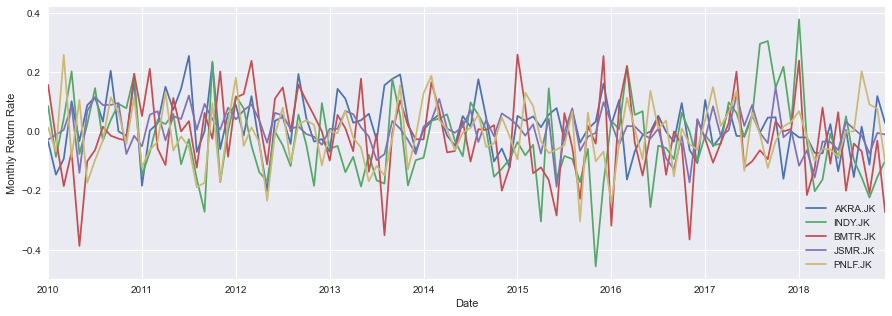

In [65]:
ret_mon[sample].plot(ylabel='Monthly Return Rate', figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Annual Return Rate'>

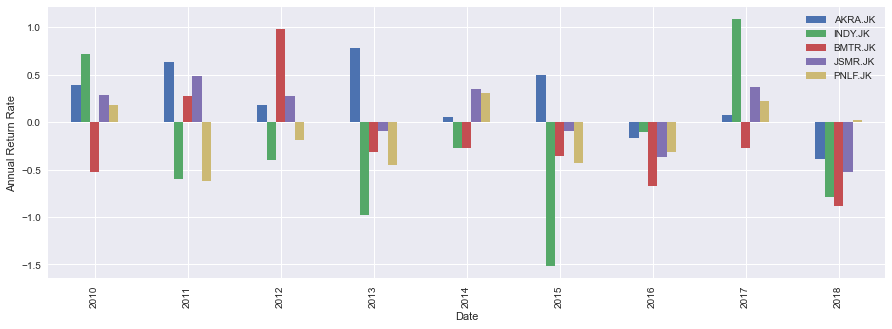

In [66]:
ret_ann[sample].plot(kind='bar', ylabel='Annual Return Rate',figsize=(15,5))

In [67]:
freq = ret.apply(lambda col: col.value_counts())

### **Distributions of Rate of Return**

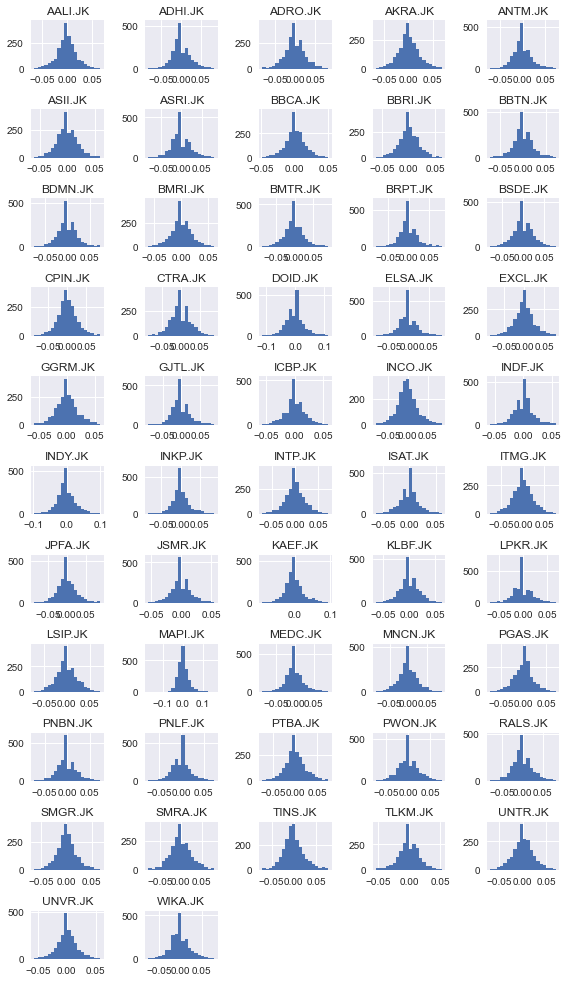

In [68]:
ret.hist(bins=20,figsize=(8,16), layout=(13,5))
plt.tight_layout()

In [69]:
# ret.iloc[:,29:].hist(bins=20,figsize=(8,16), layout=(13,5))
# plt.tight_layout()

# **Correlation Matrix of Stocks**

In [70]:
corr_matrix = ret.corr()#.ewm(span=300).corr()
#corr_matrix = corr_matrix.loc[corr_matrix.index.levels[0][-1]]

In [71]:
# corr_matrix.info()

<AxesSubplot:>

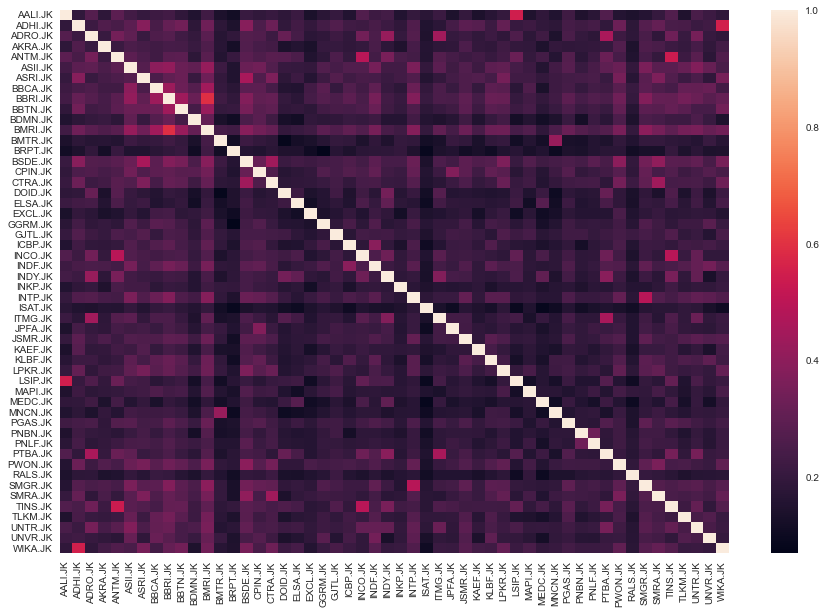

In [72]:
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix)

## **Distance Matrix**

This is an _experimental_ variable where each stock is assigned a _score_ based on its average correlation value to other stocks in KOMPAS100. A low score may suggests that the stock is highly uncorrelated to other stocks and may help in building a highly diversified portfolio.

In [73]:
dist_matrix = np.sqrt((1-corr_matrix)*2)

In [74]:
from sklearn.metrics import pairwise_distances

dist_matrix_sk = pd.DataFrame(pairwise_distances(ret.T), index=ret.columns, columns=ret.columns).round(3)

In [75]:
dist_matrix_sk

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
AALI.JK,0.000,1.330,1.289,1.249,1.146,1.137,1.317,1.040,1.133,1.240,...,1.240,1.331,1.392,1.208,1.375,1.227,1.126,1.204,1.095,1.278
ADHI.JK,1.330,0.000,1.450,1.307,1.312,1.226,1.262,1.178,1.205,1.237,...,1.424,1.300,1.479,1.254,1.380,1.362,1.209,1.360,1.234,1.044
ADRO.JK,1.289,1.450,0.000,1.386,1.252,1.251,1.456,1.207,1.266,1.365,...,1.187,1.427,1.504,1.306,1.523,1.310,1.270,1.268,1.284,1.431
AKRA.JK,1.249,1.307,1.386,0.000,1.257,1.168,1.330,1.092,1.174,1.247,...,1.337,1.282,1.435,1.184,1.371,1.315,1.144,1.255,1.167,1.283
ANTM.JK,1.146,1.312,1.252,1.257,0.000,1.123,1.298,1.073,1.125,1.190,...,1.219,1.290,1.414,1.182,1.403,0.999,1.117,1.207,1.159,1.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,1.227,1.362,1.310,1.315,0.999,1.191,1.345,1.140,1.172,1.229,...,1.247,1.346,1.454,1.235,1.411,0.000,1.187,1.243,1.220,1.294
TLKM.JK,1.126,1.209,1.270,1.144,1.117,0.982,1.227,0.867,0.957,1.082,...,1.221,1.180,1.307,1.037,1.273,1.187,0.000,1.123,0.956,1.175
UNTR.JK,1.204,1.360,1.268,1.255,1.207,1.079,1.322,1.049,1.120,1.252,...,1.214,1.327,1.423,1.173,1.374,1.243,1.123,0.000,1.136,1.310
UNVR.JK,1.095,1.234,1.284,1.167,1.159,0.995,1.260,0.880,1.014,1.127,...,1.223,1.221,1.304,1.068,1.288,1.220,0.956,1.136,0.000,1.194


<AxesSubplot:>

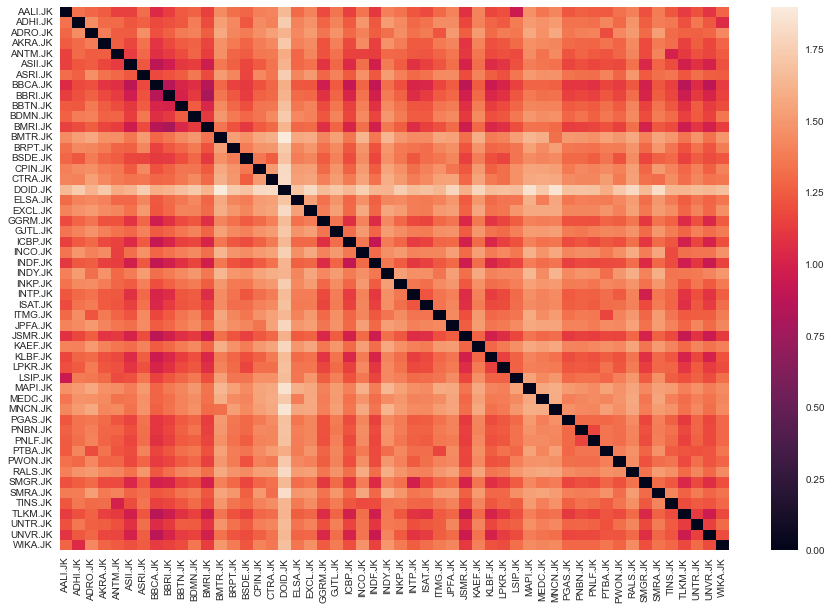

In [76]:
plt.subplots(figsize=(15,10))
sns.heatmap(dist_matrix_sk)

In [77]:
from scipy.spatial.distance import pdist
cond_dist_matrix = pdist(ret)

In [78]:
cond_dist_matrix

array([0.2407549 , 0.22807455, 0.17914825, ..., 0.18143608, 0.14345356,
       0.12212567])

## **Market (KOMPAS100 Index) Rate of Return**

In [79]:
market_price = df2[:training_year]['Close']
rate_market = log_rate(market_price).interpolate(method='time')
rate_market

Date
2010-01-05    0.012389
2010-01-06   -0.001602
2010-01-07   -0.006960
2010-01-08    0.010556
2010-01-11    0.006463
                ...   
2018-12-20   -0.005739
2018-12-21    0.001597
2018-12-26   -0.008225
2018-12-27    0.010112
2018-12-28   -0.003301
Name: Close, Length: 2205, dtype: float64

In [80]:
rate_market_ann=market_price.resample('Y').ffill().pct_change().dropna()

In [81]:
rate_market_annual = rate_market_ann.mean()

In [82]:
rate_market_annual

0.05646852263819893

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

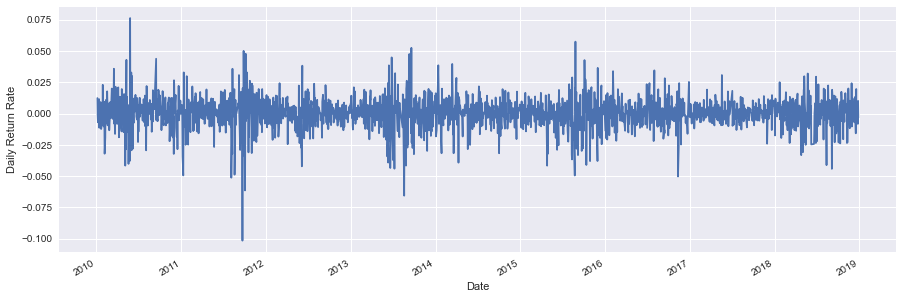

In [83]:
rate_market.plot(legend=False, ylabel='Daily Return Rate', figsize=(15,5))

## **Daily Bond Yield**

In [84]:
rate_bond = bond_yield['Close'][:training_year]
rate_bond.mean()

0.06263448149840099

In [85]:
daily_rf = (rate_bond)*(1/(365))
daily_rf

Date
2010-01-04    0.000207
2010-01-05    0.000174
2010-01-06    0.000185
2010-01-07    0.000170
2010-01-08    0.000181
                ...   
2018-12-20    0.000178
2018-12-21    0.000178
2018-12-26    0.000177
2018-12-27    0.000175
2018-12-28    0.000173
Name: Close, Length: 2189, dtype: float64

<AxesSubplot:xlabel='Date', ylabel='Daily Risk-free Rate'>

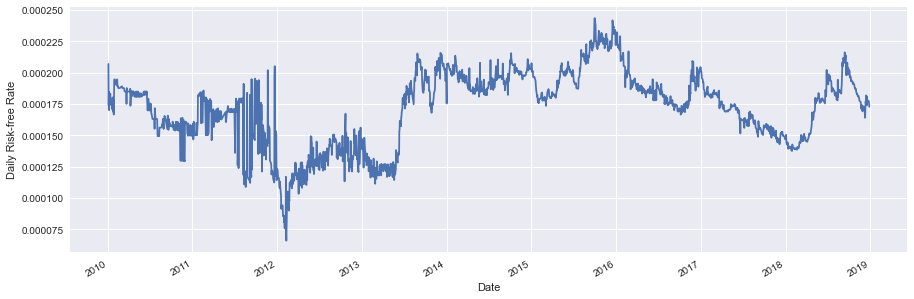

In [86]:
daily_rf.plot(ylabel='Daily Risk-free Rate', figsize=(15,5))

## **Excess Market Returns**

In [87]:
excess_ret_mar = ret.apply(lambda column: column-rate_market[rate_market.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

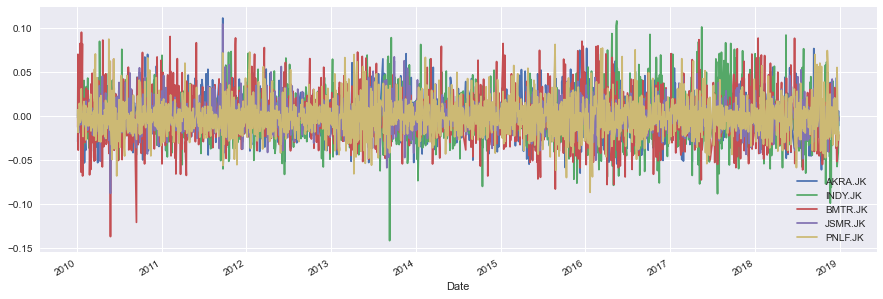

In [88]:
excess_ret_mar[sample].plot(figsize=(15,5))

In [89]:
excess_ret_mar

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002180,-0.037081,0.010211,-0.028918,-0.012389,-0.006739,0.006480,-0.002536,-0.005999,-0.012389,...,-0.012389,0.006660,0.060637,0.000683,0.005003,0.010868,-0.007167,0.012770,0.018794,-0.012389
2010-01-06,-0.002539,0.014024,0.007173,-0.006767,0.001602,-0.004048,0.001602,-0.028251,-0.011219,0.001602,...,0.023825,-0.056667,-0.026972,0.014505,0.018696,0.013031,-0.008870,-0.001509,-0.007209,0.001602
2010-01-07,0.045622,0.019230,0.028939,-0.009989,0.028466,-0.024697,0.016262,0.011998,-0.006027,0.006960,...,0.009703,-0.003091,-0.022454,-0.005943,0.006960,-0.004469,-0.019708,-0.005579,-0.010898,0.006960
2010-01-08,-0.002604,0.001565,0.052623,-0.019140,-0.010556,-0.004725,0.016843,-0.036003,-0.004042,0.021192,...,-0.007820,-0.000506,-0.025594,-0.017071,-0.010556,-0.010556,0.000197,0.023556,-0.006062,-0.025824
2010-01-11,-0.018415,-0.018584,0.003689,0.010631,-0.017158,0.009399,0.046181,0.003794,-0.006463,-0.027516,...,-0.017452,-0.006463,-0.037235,0.006524,-0.006463,0.004966,0.004176,0.044068,0.002466,-0.006463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,0.033797,-0.003421,0.013739,-0.003414,0.012296,0.011656,-0.012172,-0.016495,0.000274,-0.017076,...,0.017518,-0.002492,0.005739,0.003563,-0.018652,-0.007506,-0.012805,0.011829,0.011279,-0.005957
2018-12-21,-0.013525,-0.013942,-0.005589,-0.006205,0.004918,-0.007514,-0.044680,0.009099,-0.009850,-0.009319,...,-0.011008,-0.009895,-0.005087,0.000580,0.010673,-0.001597,0.003737,-0.032422,0.027801,0.010099
2018-12-26,-0.045176,-0.020124,-0.016068,-0.003390,0.008225,-0.028033,0.003142,0.018807,0.002684,-0.007401,...,0.022309,-0.008583,0.008225,0.012563,-0.054689,-0.018804,0.000214,-0.020816,-0.015115,-0.009371


## **Market Premium**

In [90]:
market_premium = (rate_market[rate_market.index.isin(daily_rf.index)] - daily_rf).dropna()
market_premium.mean()

0.00013656166606135662

<AxesSubplot:xlabel='Date'>

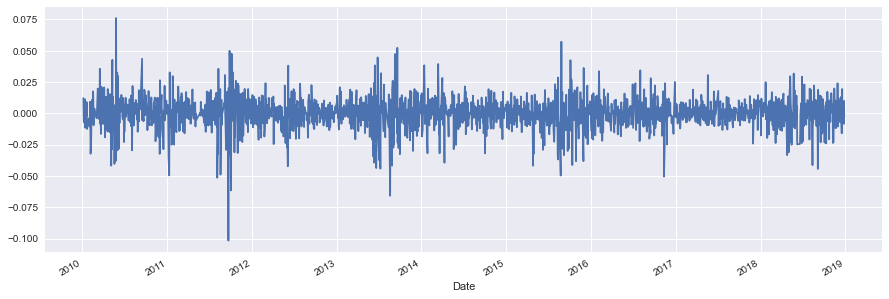

In [91]:
market_premium.plot(figsize=(15,5))

In [92]:
market_premium.sort_values()

Date
2011-09-22   -0.101680
2013-08-19   -0.065799
2011-10-03   -0.061567
2011-08-05   -0.051411
2016-11-11   -0.050456
                ...   
2011-10-06    0.047585
2011-09-27    0.049916
2013-09-19    0.052321
2015-08-27    0.057259
2010-05-26    0.076126
Name: Close, Length: 2188, dtype: float64

## **Risk Premium**

In [93]:
risk_premium = ret.apply(lambda column: column-daily_rf[daily_rf.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

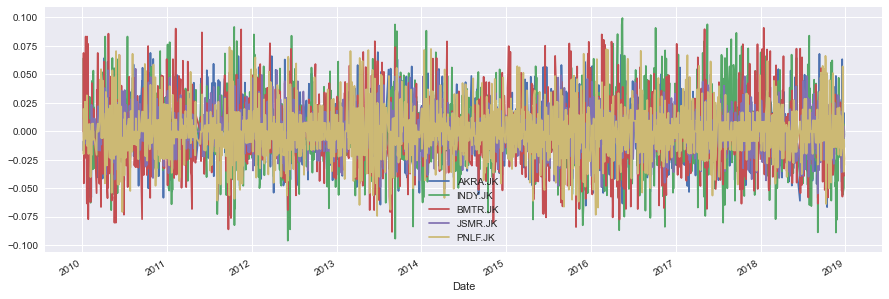

In [94]:
risk_premium[sample].plot(figsize=(15,5))

In [95]:
risk_premium

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014395,-0.024867,0.022426,-0.016703,-0.000174,0.005476,0.018695,0.009679,0.006216,-0.000174,...,-0.000174,0.018874,0.072852,0.012898,0.017218,0.023083,0.005048,0.024984,0.031009,-0.000174
2010-01-06,-0.004325,0.012238,0.005387,-0.008553,-0.000185,-0.005834,-0.000185,-0.030038,-0.013005,-0.000185,...,0.022038,-0.058454,-0.028758,0.012719,0.016910,0.011244,-0.010656,-0.003295,-0.008996,-0.000185
2010-01-07,0.038492,0.012100,0.021809,-0.017119,0.021336,-0.031827,0.009132,0.004868,-0.013157,-0.000170,...,0.002573,-0.010220,-0.029584,-0.013073,-0.000170,-0.011599,-0.026838,-0.012709,-0.018027,-0.000170
2010-01-08,0.007771,0.011940,0.062998,-0.008765,-0.000181,0.005650,0.027218,-0.025628,0.006334,0.031568,...,0.002555,0.009869,-0.015219,-0.006696,-0.000181,-0.000181,0.010572,0.033931,0.004313,-0.015449
2010-01-11,-0.012133,-0.012301,0.009972,0.016914,-0.010875,0.015682,0.052464,0.010076,-0.000180,-0.021234,...,-0.011169,-0.000180,-0.030952,0.012807,-0.000180,0.011249,0.010458,0.050351,0.008748,-0.000180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,0.027880,-0.009338,0.007822,-0.009331,0.006379,0.005739,-0.018089,-0.022412,-0.005642,-0.022993,...,0.011601,-0.008409,-0.000178,-0.002354,-0.024569,-0.013423,-0.018722,0.005912,0.005362,-0.011874
2018-12-21,-0.012106,-0.012524,-0.004170,-0.004786,0.006337,-0.006095,-0.043261,0.010518,-0.008431,-0.007900,...,-0.009589,-0.008476,-0.003668,0.001999,0.012092,-0.000178,0.005156,-0.031003,0.029220,0.011518
2018-12-26,-0.053578,-0.028525,-0.024470,-0.011792,-0.000177,-0.036435,-0.005260,0.010405,-0.005717,-0.015802,...,0.013908,-0.016984,-0.000177,0.004161,-0.063091,-0.027206,-0.008188,-0.029217,-0.023516,-0.017773


In [96]:
def reg_plot(x,y):
    exog = x[x.index.isin(y.index)]
    endog = y[y.index.isin(x.index)]
    reg_analysis=pd.DataFrame({'Risk Premium': endog, 'Market Premium':exog})
    fig, ax = plt.subplots()
    sns.regplot(x='Market Premium', y= 'Risk Premium', data= reg_analysis, ci=None,\
            line_kws={'color':'r'},scatter_kws={"s": 20}, ax=ax)
    ax.axhline(y=0, color='k', linewidth=1)  
    ax.axvline(x=0, color='k', linewidth=1)

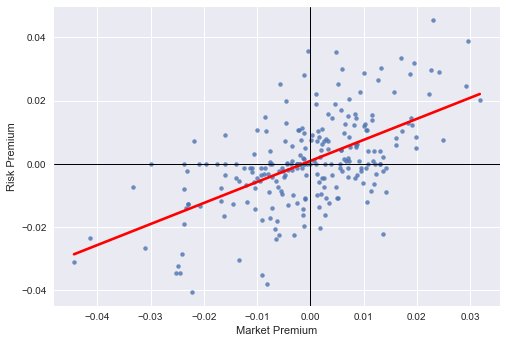

In [97]:
y = risk_premium['BBCA.JK'].loc[training_year]
x = market_premium.loc[training_year]
reg_plot(x,y)

## **Daily Sharpe**

In [98]:
daily_sr = (risk_premium/daily_movt)

In [99]:
daily_sr.replace([np.inf, -np.inf], np.nan, inplace=True)

In [100]:
daily_sr.dropna(inplace=True)

## **Instruments Analysis**

In [101]:
def lin_regression(asset_ret, market_ret):
    stock = asset_ret[asset_ret.index.isin(market_ret.index)] 
    market = market_ret[market_ret.index.isin(stock.index)] 
    reg = stock.apply(lambda col: stats.linregress(col.dropna(), market[market.index.isin(col.dropna().index)]))
    return reg

In [102]:
#Training Data
train_ret = ret[:training_year]
res= pd.DataFrame()
metrics =pd.DataFrame()
sharpe =pd.DataFrame()
risk=pd.DataFrame()

for year in range(2010, int(training_year)):
    
    yr = f'{year}'

    #Covariances
    tr_cov = train_ret[:yr].cov()
    tr_std = train_ret[:yr].std()
    tr_semicov = train_ret[:yr][train_ret[:yr] < 0].cov()
    tr_mar_cov = train_ret[:yr].apply(lambda col: col.cov(rate_market[:yr]))
    tr_mar_var = rate_market[:yr].var()

    #Regression
    tr_y = risk_premium.loc[:yr]
    tr_x = market_premium.loc[:yr]
    reg = lin_regression(tr_y,tr_x)
    tr_alpha = reg.iloc[1]
    tr_beta = reg.iloc[0]
    tr_rsq = reg.iloc[2]
    tr_sse = reg.iloc[4]


    #Expected Returns Market
    tr_market_er = rate_market[:yr].mean()*252
    tr_risk_free = daily_rf[:yr].mean()*365
    tr_er_marketprem = (tr_market_er - tr_risk_free)

    #CAPM Beta 
    tr_beta_stat = tr_mar_cov.divide(tr_mar_var)

    #LReg Expected Return
    tr_beta_prem = tr_beta.apply(lambda x: x*(market_premium.loc[yr])).T
    tr_lreg_ret = tr_alpha + tr_beta_prem.sum() + tr_risk_free
    tr_exp_ret = tr_lreg_ret

    #CAPM Expected Return
    tr_beta_prem_stat = tr_beta_stat*tr_er_marketprem
    tr_ols = (tr_beta_prem_stat + tr_risk_free)
    tr_exp_ret_stat = tr_ols

    #Annualised Return
    tr_mean_ret = train_ret[:yr].mean()
    tr_ind_er = tr_mean_ret*(252)
    
    #Exponentially Weighted 
    tr_300ewm_ret = train_ret[:yr].ewm(span=300).mean().iloc[-1]
    tr_300ewm_er = tr_300ewm_ret*252
    tr_500ewm_ret = train_ret[:yr].ewm(span=500).mean().iloc[-1]
    tr_500ewm_er = tr_500ewm_ret*252
    tr300_sd = train_ret[:yr].ewm(span=300).std().iloc[-1]*np.sqrt(252)
    tr300_semisd= train_ret[:yr][train_ret[:yr]<0].ewm(span=300).std().iloc[-1]*np.sqrt(252)
    tr500_sd = train_ret[:yr].ewm(span=500).std().iloc[-1]*np.sqrt(252)
    tr500_semisd= train_ret[:yr][train_ret[:yr]<0].ewm(span=500).std().iloc[-1]*np.sqrt(252)
    
    #Ex-ante Sharpe
    tr_sharpe_ante = (tr_exp_ret - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_capm = (tr_exp_ret_stat - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_ann = (tr_ind_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_300ewm = (tr_300ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_500ewm = (tr_500ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    
    #Real Return 2019
    tr_ret = ret_ann.loc[f'{year+1}']
    tr_real_std = ret.loc[f'{year+1}'].std()
    
    #Ex-post Sharpe
    tr_sharpe_post = (tr_ret - tr_risk_free)/(tr_real_std*np.sqrt(252))    
    
    rets_data = pd.DataFrame({'Exp. Ret. (LinReg)': tr_exp_ret, 'Exp. Ret. (OLS)': tr_exp_ret_stat, 'Exp. Annualised Return': tr_ind_er, 'Exp. 300 EMA Return':tr_300ewm_er,'Exp. 500 EMA Return':tr_500ewm_er,
                              'Realised Return': tr_ret}).T.stack()
    metrics_data = pd.DataFrame({'Beta(CAPM)':tr_beta_stat, 'Beta (LinReg)': tr_beta, 'Alpha (LinReg)':tr_alpha}).T.stack()
    sharpe_data = pd.DataFrame({'Ex-Ante Sharpe LinReg':tr_sharpe_ante, 'Ex-Ante Sharpe CAPM':tr_sharpe_ante_capm, 'Ex-Ante Sharpe AnnRet':tr_sharpe_ante_ann, 
                                'Ex-Ante Sharpe 300 EMA':tr_sharpe_ante_300ewm, 'Ex-Ante Sharpe 500 EMA':tr_sharpe_ante_500ewm,'Ex-Post Sharpe':tr_sharpe_post}).T.stack()
    risk_data = pd.DataFrame({'Expected Volatility': tr_std*np.sqrt(252), 'EMA-300 Volatility': tr300_sd,'EMA-500 Volatility': tr500_sd, 'Realised Volatility':tr_real_std*np.sqrt(252)}).T.stack()
    
    res[f'{year+1}'] = rets_data
    metrics[f'{year+1}'] = metrics_data
    sharpe[f'{year+1}'] = sharpe_data
    risk[f'{year+1}'] = risk_data


In [103]:
res_mean_ann=res.groupby(axis=0, level=0).mean().T

<AxesSubplot:title={'center':'Annual Average of Returns'}>

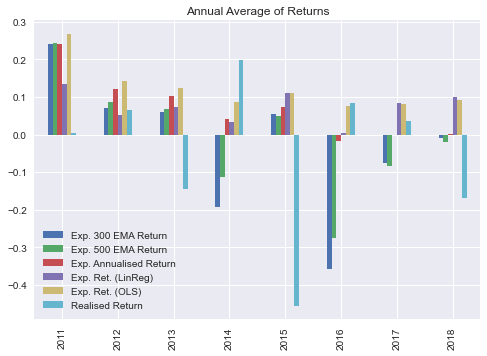

In [104]:
res_mean_ann.plot(kind='bar', title='Annual Average of Returns')

In [105]:
ttest_rets = res_mean_ann.apply(lambda col: stats.ttest_ind(col, res_mean_ann['Realised Return']))
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [106]:
ttest_rets

,Exp. 300 EMA Return,Exp. 500 EMA Return,Exp. Annualised Return,Exp. Ret. (LinReg),Exp. Ret. (OLS),Realised Return
t-statistics,0.222791,0.459279,1.510591,1.652822,2.248858,0.0
p-value,0.826916,0.653084,0.153131,0.120608,0.041142,1.0


In [107]:
res_mean_ann.corr()

,Exp. 300 EMA Return,Exp. 500 EMA Return,Exp. Annualised Return,Exp. Ret. (LinReg),Exp. Ret. (OLS),Realised Return
Exp. 300 EMA Return,1.000000,0.987972,0.819569,0.847916,0.776617,-0.408217
Exp. 500 EMA Return,0.987972,1.000000,0.891564,0.789732,0.837366,-0.329122
Exp. Annualised Return,0.819569,0.891564,1.000000,0.539578,0.955982,-0.051521
Exp. Ret. (LinReg),0.847916,0.789732,0.539578,1.000000,0.593700,-0.596183
Exp. Ret. (OLS),0.776617,0.837366,0.955982,0.593700,1.000000,0.004750
Realised Return,-0.408217,-0.329122,-0.051521,-0.596183,0.004750,1.000000


In [108]:
res_mean_ann.apply(lambda col: (np.square(res_mean_ann['Realised Return']-col)).mean())

Exp. 300 EMA Return       0.093239
Exp. 500 EMA Return       0.077716
Exp. Annualised Return    0.058297
Exp. Ret. (LinReg)        0.061924
Exp. Ret. (OLS)           0.068646
Realised Return           0.000000
dtype: float64

In [109]:
metrics

2011      2012      2013      2014      2015  \
Beta(CAPM)     AALI.JK  0.762264  0.669005  0.713368  0.629167  0.632838   
               ADHI.JK  0.850061  0.797992  0.840150  0.862796  0.934687   
               ADRO.JK  0.862727  0.920712  0.987688  0.920379  0.932140   
               AKRA.JK  0.854440  0.782662  0.848484  0.789700  0.778682   
               ANTM.JK  1.004409  0.867832  0.881997  0.816823  0.786820   
...                          ...       ...       ...       ...       ...   
Alpha (LinReg) TINS.JK  0.001069  0.000559  0.000426  0.000277  0.000359   
               TLKM.JK  0.001423  0.000709  0.000455  0.000256  0.000251   
               UNTR.JK  0.000718  0.000105  0.000380  0.000090  0.000261   
               UNVR.JK  0.000755  0.000085  0.000071 -0.000012  0.000076   
               WIKA.JK  0.000387  0.000161 -0.000028 -0.000104 -0.000109   

                            2016      2017      2018  
Beta(CAPM)     AALI.JK  0.655392  0.631634  0.624904  
               ADHI.JK  0.930478  0.913182  0.907482  
               ADRO.JK  0.914817  0.908588  0.919928  
               AKRA.JK  0.701199  0.701182  0.707693  
               ANTM.JK  0.768136  0.754818  0.744872  
...                          ...       ...       ...  
Alpha (LinReg) TINS.JK  0.000345  0.000285  0.000389  
               TLKM.JK  0.000077  0.000065  0.000146  
               UNTR.JK  0.000092  0.000120  0.000123  
               UNVR.JK -0.000046 -0.000037 -0.000021  
               WIKA.JK -0.000126 -0.000032  0.000113  

[156 rows x 8 columns]

<AxesSubplot:>

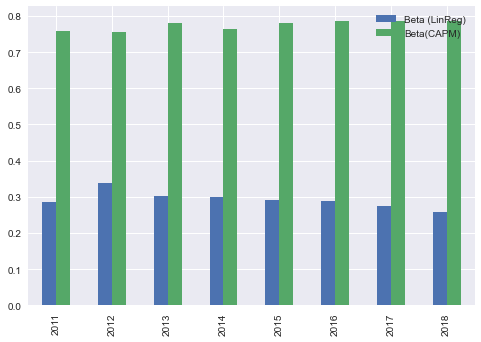

In [110]:
annual_betas = metrics.groupby(level=0).mean().drop('Alpha (LinReg)')
annual_betas.T.plot(kind='bar')

In [111]:
sharpe

2011      2012      2013      2014  \
Ex-Ante Sharpe LinReg AALI.JK  0.266629 -0.032314  0.063055 -0.076436   
                      ADHI.JK  0.138250 -0.018482  0.036353 -0.045839   
                      ADRO.JK  0.226310 -0.023612  0.054497 -0.064749   
                      AKRA.JK  0.193858 -0.026635  0.052734 -0.069476   
                      ANTM.JK  0.271133 -0.036430  0.080957 -0.087853   
...                                 ...       ...       ...       ...   
Ex-Post Sharpe        TINS.JK -0.476029  0.013805 -0.361388  0.048148   
                      TLKM.JK -0.496375  0.472110  0.007225  1.397363   
                      UNTR.JK  0.329041 -1.038409  0.756506 -0.388564   
                      UNVR.JK  0.829238  0.671042 -0.502581  0.817672   
                      WIKA.JK -0.693263  1.842115 -0.001401  2.520315   

                                   2015      2016      2017      2018  
Ex-Ante Sharpe LinReg AALI.JK  0.162665 -0.161767  0.058708  0.112161  
                      ADHI.JK  0.107701 -0.119722  0.047975  0.087415  
                      ADRO.JK  0.131957 -0.134170  0.045588  0.083367  
                      AKRA.JK  0.153563 -0.155482  0.055459  0.099962  
                      ANTM.JK  0.191109 -0.190948  0.069803  0.120865  
...                                 ...       ...       ...       ...  
Ex-Post Sharpe        TINS.JK -2.378450  0.475176 -1.915709 -0.658382  
                      TLKM.JK -0.179853  0.554668 -0.491843 -0.461387  
                      UNTR.JK -0.122402 -0.083338  1.043249 -0.649229  
                      UNVR.JK -0.361178  0.588835  1.873399 -0.913735  
                      WIKA.JK -1.806500 -0.680937 -1.725066  0.175449  

[312 rows x 8 columns]

In [112]:
sharpe_mean_ann=sharpe.groupby(axis=0, level=0).mean().T

In [113]:
ttest_sharpe = sharpe_mean_ann.apply(lambda col: stats.ttest_ind(col, sharpe_mean_ann['Ex-Post Sharpe']))
ttest_sharpe.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [114]:
ttest_sharpe

,Ex-Ante Sharpe 300 EMA,Ex-Ante Sharpe 500 EMA,Ex-Ante Sharpe AnnRet,Ex-Ante Sharpe CAPM,Ex-Ante Sharpe LinReg,Ex-Post Sharpe
t-statistics,0.179112,0.417768,1.499669,2.219882,1.594312,0.0
p-value,0.860416,0.682453,0.155910,0.043448,0.133186,1.0


In [115]:
risk_mean_ann = risk.groupby(level=0).mean().T

<AxesSubplot:title={'center':'Annual Average of Volatilities'}>

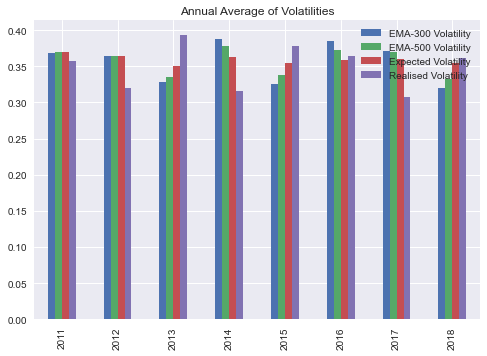

In [116]:
risk_mean_ann.plot(kind='bar', title='Annual Average of Volatilities')

In [117]:
ttest_risk = risk_mean_ann.apply(lambda col: stats.ttest_ind(col, risk_mean_ann['Realised Volatility']))
ttest_risk.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [118]:
ttest_risk

,EMA-300 Volatility,EMA-500 Volatility,Expected Volatility,Realised Volatility
t-statistics,0.430570,0.577279,0.822257,0.0
p-value,0.673336,0.572918,0.424714,1.0


## **Instruments Calculations**

In [119]:
cov = ret.cov()

In [120]:
semicov = ret[ret < 0].cov()

In [121]:
mar_cov = ret.apply(lambda col: col.cov(rate_market[rate_market.index.isin(col.index)]))
mar_cov

AALI.JK    0.000093
ADHI.JK    0.000139
ADRO.JK    0.000143
AKRA.JK    0.000111
ANTM.JK    0.000119
             ...   
TINS.JK    0.000130
TLKM.JK    0.000107
UNTR.JK    0.000141
UNVR.JK    0.000111
WIKA.JK    0.000126
Length: 52, dtype: float64

In [122]:
mar_var = rate_market.var()
mar_var

0.00015522105682495003

In [123]:
y = risk_premium
x = market_premium
reg = lin_regression(y,x)

In [124]:
alpha = reg.iloc[1]
beta = reg.iloc[0]
rsq = reg.iloc[2]
sse = reg.iloc[4]

In [125]:
beta.sort_values()

DOID.JK    0.121778
MEDC.JK    0.148496
BRPT.JK    0.155189
RALS.JK    0.160502
BMTR.JK    0.166296
             ...   
TLKM.JK    0.390860
ASII.JK    0.408371
BBRI.JK    0.425147
BMRI.JK    0.437994
BBCA.JK    0.503364
Name: 0, Length: 52, dtype: float64

In [126]:
alpha.sort_values()

CPIN.JK   -0.000142
BBCA.JK   -0.000134
BBRI.JK   -0.000101
MAPI.JK   -0.000060
AKRA.JK   -0.000054
             ...   
AALI.JK    0.000349
INDY.JK    0.000400
ELSA.JK    0.000404
DOID.JK    0.000456
ANTM.JK    0.000466
Name: 1, Length: 52, dtype: float64

In [127]:
rsq.sort_values()

BRPT.JK    0.275836
ISAT.JK    0.295305
MEDC.JK    0.297151
RALS.JK    0.321092
DOID.JK    0.321134
             ...   
BSDE.JK    0.533107
BBCA.JK    0.599127
ASII.JK    0.621771
BBRI.JK    0.642818
BMRI.JK    0.666125
Name: 2, Length: 52, dtype: float64

In [128]:
sse

AALI.JK    0.012413
ADHI.JK    0.009802
ADRO.JK    0.009467
AKRA.JK    0.011292
ANTM.JK    0.011332
             ...   
TINS.JK    0.010341
TLKM.JK    0.013813
UNTR.JK    0.010489
UNVR.JK    0.013322
WIKA.JK    0.010569
Name: 4, Length: 52, dtype: float64

In [129]:
market_er = rate_market.mean()*252
risk_free = daily_rf.mean()*252
er_marketprem = (market_er - risk_free)

In [130]:
er_marketprem

0.037027276247174425

In [131]:
beta_stat = mar_cov.divide(mar_var)
beta_stat

AALI.JK    0.599067
ADHI.JK    0.894652
ADRO.JK    0.921472
AKRA.JK    0.712328
ANTM.JK    0.766450
             ...   
TINS.JK    0.837835
TLKM.JK    0.690880
UNTR.JK    0.905988
UNVR.JK    0.715428
WIKA.JK    0.810605
Length: 52, dtype: float64

In [132]:
beta_prem = beta.apply(lambda row: row*market_premium[training_year]).T

In [133]:
beta_prem

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,-0.000440,-0.000446,-0.000425,-0.000448,-0.000508,-0.000775,-0.000445,-0.000955,-0.000807,-0.000563,...,-0.000435,-0.000493,-0.000305,-0.000625,-0.000423,-0.000459,-0.000742,-0.000556,-0.000716,-0.000465
2018-01-03,-0.004087,-0.004141,-0.003947,-0.004162,-0.004716,-0.007194,-0.004128,-0.008868,-0.007490,-0.005227,...,-0.004039,-0.004579,-0.002827,-0.005799,-0.003923,-0.004264,-0.006886,-0.005156,-0.006647,-0.004314
2018-01-04,0.001990,0.002017,0.001923,0.002027,0.002297,0.003504,0.002011,0.004319,0.003648,0.002546,...,0.001967,0.002230,0.001377,0.002824,0.001911,0.002077,0.003354,0.002511,0.003238,0.002101
2018-01-05,0.002742,0.002778,0.002648,0.002792,0.003164,0.004827,0.002770,0.005950,0.005025,0.003507,...,0.002710,0.003072,0.001897,0.003891,0.002632,0.002861,0.004620,0.003460,0.004460,0.002895
2018-01-08,0.001339,0.001357,0.001293,0.001363,0.001545,0.002357,0.001352,0.002905,0.002454,0.001712,...,0.001323,0.001500,0.000926,0.001900,0.001285,0.001397,0.002256,0.001689,0.002178,0.001413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,-0.001373,-0.001391,-0.001326,-0.001398,-0.001584,-0.002416,-0.001387,-0.002978,-0.002516,-0.001755,...,-0.001357,-0.001538,-0.000950,-0.001948,-0.001318,-0.001432,-0.002313,-0.001732,-0.002233,-0.001449
2018-12-21,0.000329,0.000334,0.000318,0.000335,0.000380,0.000579,0.000333,0.000714,0.000603,0.000421,...,0.000325,0.000369,0.000228,0.000467,0.000316,0.000343,0.000555,0.000415,0.000535,0.000347
2018-12-26,-0.001949,-0.001975,-0.001883,-0.001985,-0.002249,-0.003431,-0.001969,-0.004229,-0.003572,-0.002493,...,-0.001926,-0.002184,-0.001348,-0.002766,-0.001871,-0.002034,-0.003284,-0.002459,-0.003170,-0.002058


In [134]:
beta_prem_stat = (beta_stat*er_marketprem)

In [135]:
beta_prem_stat.sort_values()

ISAT.JK    0.016995
BRPT.JK    0.018412
AALI.JK    0.022182
MEDC.JK    0.022302
JSMR.JK    0.022362
             ...   
BBRI.JK    0.036313
CTRA.JK    0.036702
BSDE.JK    0.037076
BMRI.JK    0.037757
CPIN.JK    0.039271
Length: 52, dtype: float64

In [136]:
lreg_ret = alpha + beta_prem.apply(lambda col: col + daily_rf)

In [137]:
exp_ret = lreg_ret.sum()

In [138]:
exp_ret = lreg_ret.sum()

In [139]:
exp_ret.sort_values()

BBCA.JK   -0.044644
BBRI.JK   -0.028319
CPIN.JK   -0.018708
INDF.JK   -0.007752
UNVR.JK   -0.007035
             ...   
MEDC.JK    0.107883
INDY.JK    0.117422
ELSA.JK    0.120550
ANTM.JK    0.124489
DOID.JK    0.137673
Length: 52, dtype: float64

In [140]:
ols = (beta_prem_stat + risk_free)

In [141]:
exp_ret_stat = ols
exp_ret_stat.sort_values()

ISAT.JK    0.060239
BRPT.JK    0.061655
AALI.JK    0.065425
MEDC.JK    0.065546
JSMR.JK    0.065606
             ...   
BBRI.JK    0.079557
CTRA.JK    0.079945
BSDE.JK    0.080320
BMRI.JK    0.081000
CPIN.JK    0.082514
Length: 52, dtype: float64

In [142]:
ret.resample('Y').sum().iloc[-1]

AALI.JK   -0.304223
ADHI.JK   -0.243048
ADRO.JK    0.000839
AKRA.JK   -0.391959
ANTM.JK   -0.151434
             ...   
TINS.JK   -0.164947
TLKM.JK   -0.075694
UNTR.JK   -0.158581
UNVR.JK   -0.186890
WIKA.JK    0.133397
Name: 2018-12-31 00:00:00, Length: 52, dtype: float64

In [143]:
real_ret = ret_ann.iloc[-1]
real_ret.sort_values()

ISAT.JK   -1.032422
MEDC.JK   -0.912933
BMTR.JK   -0.881615
LPKR.JK   -0.800140
INDY.JK   -0.792015
             ...   
ICBP.JK    0.200805
MAPI.JK    0.265005
PTBA.JK    0.777129
CPIN.JK    0.935420
INKP.JK    1.022067
Name: 2018, Length: 52, dtype: float64

In [144]:
ewm300 = ret.ewm(span=300).mean()

In [145]:
ewm300_er = ewm300.iloc[-1]*252

In [146]:
mean_ret = ret.mean()

In [147]:
ind_er = mean_ret*252
ind_er.sort_values()

DOID.JK   -0.625417
ELSA.JK   -0.372633
INDY.JK   -0.324962
MEDC.JK   -0.304167
ANTM.JK   -0.266899
             ...   
BBRI.JK    0.176494
KLBF.JK    0.191859
AKRA.JK    0.233818
MAPI.JK    0.297381
CPIN.JK    0.323484
Length: 52, dtype: float64

In [148]:
returns = pd.DataFrame({'Exp. Ret. (LinReg)': exp_ret, 'Exp. Ret. (OLS)': exp_ret_stat, 'Annualised Return': ind_er, 'EMA-300 Return': ewm300_er, 'Realised Return':real_ret})

In [149]:
returns.mean()#.plot(kind='bar')

Exp. Ret. (LinReg)    0.053163
Exp. Ret. (OLS)       0.072433
Annualised Return    -0.016990
EMA-300 Return       -0.137248
Realised Return      -0.168728
dtype: float64

In [150]:
returns.sample(n=10)

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
PNLF.JK,0.091249,0.068646,-0.146592,0.103107,0.017679
ELSA.JK,0.120550,0.066518,-0.372633,-0.297202,-0.215833
INDY.JK,0.117422,0.076157,-0.324962,-0.790133,-0.792015
INKP.JK,0.043797,0.069492,0.082424,0.664630,1.022067
UNVR.JK,-0.007035,0.069734,0.151572,0.013692,-0.186890
BBCA.JK,-0.044644,0.069915,0.172087,0.244121,0.182466
CTRA.JK,0.054988,0.079945,0.036575,-0.007919,-0.173475
BRPT.JK,0.081118,0.061655,-0.103649,0.395322,0.073740
EXCL.JK,0.067323,0.069970,-0.015140,-0.461121,-0.515901
BBRI.JK,-0.028319,0.079557,0.176494,0.296810,0.072417


In [151]:
returns.corr()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),1.000000,-0.283911,-0.927008,-0.597989,-0.427661
Exp. Ret. (OLS),-0.283911,1.000000,0.297200,0.235191,0.210651
Annualised Return,-0.927008,0.297200,1.000000,0.620976,0.472714
EMA-300 Return,-0.597989,0.235191,0.620976,1.000000,0.923136
Realised Return,-0.427661,0.210651,0.472714,0.923136,1.000000


In [152]:
returns.cov()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),0.001826,-0.000060,-0.007122,-0.010413,-0.007449
Exp. Ret. (OLS),-0.000060,0.000025,0.000266,0.000477,0.000428
Annualised Return,-0.007122,0.000266,0.032313,0.045484,0.034633
EMA-300 Return,-0.010413,0.000477,0.045484,0.166031,0.153309
Realised Return,-0.007449,0.000428,0.034633,0.153309,0.166118


In [153]:
ttest_rets = returns.apply(lambda col: stats.ttest_ind(col, real_ret))

In [154]:
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [155]:
ttest_rets

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
t-statistics,3.904426,4.266465,2.456352,0.393883,0.0
p-value,0.000170,0.000045,0.015725,0.694489,1.0


In [156]:
returns.apply(lambda col: (np.square(returns['Realised Return']-col)).mean())

Exp. Ret. (LinReg)    0.228562
Exp. Ret. (OLS)       0.220267
Annualised Return     0.149704
EMA-300 Return        0.026030
Realised Return       0.000000
dtype: float64

In [157]:
ann_mon_er = ret_mon.apply(lambda col: col.mean()*12)
ann_mon_er.sort_values()

DOID.JK   -0.611354
ELSA.JK   -0.364254
INDY.JK   -0.317655
MEDC.JK   -0.297327
ANTM.JK   -0.260897
             ...   
BBRI.JK    0.172525
KLBF.JK    0.187544
AKRA.JK    0.228560
MAPI.JK    0.290694
CPIN.JK    0.316209
Length: 52, dtype: float64

In [158]:
ret_ann.tail(3).mean().sort_values()

BMTR.JK   -0.610329
MEDC.JK   -0.575397
LPKR.JK   -0.514128
MNCN.JK   -0.492363
SMRA.JK   -0.420411
             ...   
PTBA.JK    0.426871
CPIN.JK    0.438673
ADRO.JK    0.497102
BRPT.JK    0.750943
INKP.JK    0.761252
Length: 52, dtype: float64

### **Ex-Ante Statistics**

In [159]:
exp_sd = ret.ewm(span=300).std().iloc[-1]*np.sqrt(252)
exp_semisd= ret[ret<0].ewm(span=300).std().iloc[-1]*np.sqrt(252)

In [160]:
exp_sd

AALI.JK    0.305508
ADHI.JK    0.343220
ADRO.JK    0.379928
AKRA.JK    0.334927
ANTM.JK    0.349582
             ...   
TINS.JK    0.325830
TLKM.JK    0.286959
UNTR.JK    0.342875
UNVR.JK    0.272216
WIKA.JK    0.399535
Name: 2018-12-31 00:00:00, Length: 52, dtype: float64

In [161]:
exp_excess_ret = ewm300_er - risk_free
exp_sharpe = exp_excess_ret / exp_sd
exp_sortino = exp_excess_ret / exp_semisd

In [162]:
exp_sharpe.sort_values()

ISAT.JK   -4.004079
BMTR.JK   -2.876025
LPKR.JK   -2.861779
MEDC.JK   -2.501956
MNCN.JK   -2.087907
             ...   
BBCA.JK    0.935636
BRPT.JK    0.941166
PTBA.JK    1.265277
INKP.JK    1.339244
CPIN.JK    2.387224
Name: 2018-12-31 00:00:00, Length: 52, dtype: float64

### **Ex-Post Statistics**

In [163]:
ann_sd = ret.std()*np.sqrt(252)
ann_sd.sort_values()

BBCA.JK    0.235390
JSMR.JK    0.254901
TLKM.JK    0.261572
UNVR.JK    0.270647
ICBP.JK    0.277544
             ...   
INCO.JK    0.420057
CTRA.JK    0.426951
INDY.JK    0.428468
MAPI.JK    0.428635
DOID.JK    0.519028
Length: 52, dtype: float64

In [164]:
ann_semisd = ret[ret<0].std()*np.sqrt(252)
ann_semisd.sort_values()

JSMR.JK    0.157449
BBCA.JK    0.160355
TLKM.JK    0.173712
INDF.JK    0.176527
UNVR.JK    0.177563
             ...   
MNCN.JK    0.259528
CPIN.JK    0.260493
BMTR.JK    0.265191
INDY.JK    0.266436
DOID.JK    0.319879
Length: 52, dtype: float64

In [165]:
_expret = ind_er
excess_ret_rf = _expret - risk_free
ann_sharpe = excess_ret_rf.div(ann_sd)
ann_sharpe.sort_values()

DOID.JK   -1.288295
ELSA.JK   -1.091577
ANTM.JK   -0.933488
MEDC.JK   -0.881311
INDY.JK   -0.859355
             ...   
KLBF.JK    0.504352
BBCA.JK    0.547362
AKRA.JK    0.558664
MAPI.JK    0.592900
CPIN.JK    0.681532
Length: 52, dtype: float64

In [166]:
ann_sortino = excess_ret_rf.divide(ann_semisd)
ann_sortino

AALI.JK   -1.081746
ADHI.JK    0.018478
ADRO.JK   -0.196802
AKRA.JK    0.925275
ANTM.JK   -1.516176
             ...   
TINS.JK   -0.917213
TLKM.JK    0.103678
UNTR.JK    0.154636
UNVR.JK    0.610084
WIKA.JK    0.388852
Length: 52, dtype: float64

In [167]:
exp_exretmar = _expret - (market_er)
ann_infratio = exp_exretmar.div(ann_sd)
ann_infratio.sort_values()

DOID.JK   -1.359635
ELSA.JK   -1.188765
ANTM.JK   -1.044936
MEDC.JK   -0.975241
INDY.JK   -0.945773
             ...   
KLBF.JK    0.378693
BBCA.JK    0.390060
AKRA.JK    0.450120
MAPI.JK    0.506516
CPIN.JK    0.591483
Length: 52, dtype: float64

In [168]:
ann_riskprem = risk_premium.mean()*252

In [169]:
ret_skew = ret.skew(axis=0)

In [170]:
ret_kurt = ret.kurtosis(axis=0)

In [171]:
ret_kurt

AALI.JK    0.968615
ADHI.JK    1.143866
ADRO.JK    0.716541
AKRA.JK    0.563300
ANTM.JK    1.235159
             ...   
TINS.JK    0.817716
TLKM.JK    0.753754
UNTR.JK    0.426291
UNVR.JK    0.996231
WIKA.JK    0.888410
Length: 52, dtype: float64

In [172]:
assets = pd.concat([exp_ret, exp_ret_stat, ind_er, ewm300_er, ret_mon[-3:-1].sum(), ret_mon[-6:-1].sum(), ret_ann[-2:-1].sum(), ann_sd,
                    ann_semisd, ann_sharpe, exp_sharpe, ann_sortino, exp_sortino, ann_infratio, ret_skew, ret_kurt, alpha, beta, beta_stat, rsq, mcap, 
                    total_volume_ratio, real_ret], axis=1) # Creating a table for visualising returns and volatility of assets

assets.columns = ['Expected Return (LinReg)', 'Expected Return (CAPM)',  'Annualised Return', 'EMA-300 Return', 'Last 3 Months Change', 'Last 6 Months Change', 
                  'Last 2 Year Change','Annualised Volatility', 'Annualised Downside Risk', 'Sharpe', 'Expected Sharpe', 'Sortino', 'Expected Sortino', 'Info. Ratio', 'Skew', 'Kurtosis', 'Alpha', 'Beta', 'Beta (CAPM)','R2',
                  'Market Cap', 'Volume-to-Market Ratio','Realised Return']
assets=assets.join([volume_data, growth_data])
assets

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
AALI.JK,0.100230,0.065425,-0.189512,-0.299898,-0.179118,-0.242007,-0.208268,0.315563,0.215166,-0.737586,...,0.231973,0.599067,0.372112,1.636000e+13,0.000373,-0.304223,0.000373,0.000372,0.102781,-0.269059
ADHI.JK,0.045403,0.076370,0.047507,-0.168100,0.118582,-0.134330,-0.345810,0.383201,0.230717,0.011125,...,0.235061,0.894652,0.457445,2.920000e+12,0.004628,-0.243048,0.004628,0.004620,0.032945,0.249786
ADRO.JK,0.060379,0.077363,-0.005975,-0.126994,-0.240532,-0.072878,0.207734,0.397966,0.250094,-0.123676,...,0.224067,0.921472,0.452733,4.318000e+13,0.014069,0.000839,0.014069,0.014056,0.110922,-0.135692
AKRA.JK,0.003172,0.069619,0.233818,-0.208725,0.007334,-0.124715,0.078596,0.341126,0.205966,0.558664,...,0.236241,0.712328,0.409453,1.476000e+13,0.002650,-0.391959,0.002650,0.002649,0.287633,0.368793
ANTM.JK,0.124489,0.071623,-0.266899,-0.442923,-0.317714,-0.290254,-0.626273,0.332240,0.204555,-0.933488,...,0.267681,0.766450,0.452014,6.224000e+13,0.011278,-0.151434,0.011278,0.011267,0.997472,10.984760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.092128,0.074266,-0.146644,-0.211581,-0.175633,-0.259283,-0.559215,0.365075,0.207026,-0.520131,...,0.242049,0.837835,0.448721,1.143000e+13,0.004331,-0.164947,0.004331,0.004323,0.195236,-0.736690
TLKM.JK,0.023772,0.068825,0.061254,0.030536,0.010929,0.065498,-0.025337,0.261572,0.173712,0.068853,...,0.390860,0.690880,0.518892,3.298800e+14,0.024632,-0.075694,0.024632,0.024621,0.019711,-0.185730
UNTR.JK,0.031213,0.076790,0.077322,-0.162700,-0.099291,-0.055941,0.421683,0.345584,0.220376,0.098610,...,0.292706,0.905988,0.513629,7.917000e+13,0.001092,-0.158581,0.001092,0.001090,0.310808,0.502861
UNVR.JK,-0.007035,0.069734,0.151572,0.013692,-0.097049,-0.077183,0.382871,0.270647,0.177563,0.400256,...,0.377339,0.715428,0.519267,1.556500e+14,0.002309,-0.186890,0.002309,0.002305,0.014502,0.296468


<AxesSubplot:title={'center':'Stocks Features (Normalised)'}>

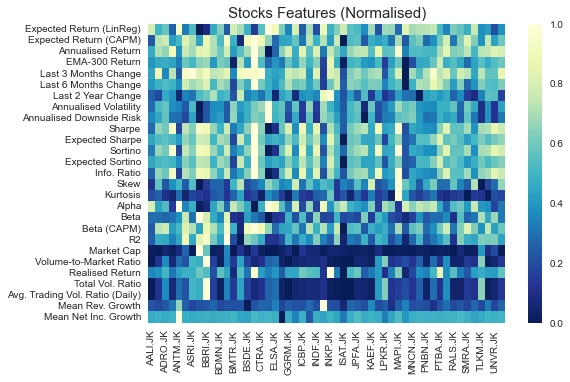

In [386]:
pd.options.display.float_format = '{:.4f}'.format
assets_sampled = assets_scaled.T
plt.title('Stocks Features (Normalised)', fontsize=15)
sns.heatmap(assets_sampled,cmap='YlGnBu_r')

In [174]:
assets_sampled.iloc[14:20]

,ANTM.JK,CTRA.JK,INKP.JK,JSMR.JK,DOID.JK
Skew,0.2304,0.1258,0.2150,0.1255,0.3291
Kurtosis,1.2352,0.5086,2.0784,0.7872,1.4556
Alpha,0.0005,0.0002,0.0001,0.0001,0.0005
Beta,0.2677,0.2106,0.1950,0.3588,0.1218
Beta (CAPM),0.7665,0.9912,0.7089,0.6039,0.8538
R2,0.4520,0.4556,0.3709,0.4648,0.3211


Text(0.5, 1.0, 'Correlation Matrix of Features 2018')

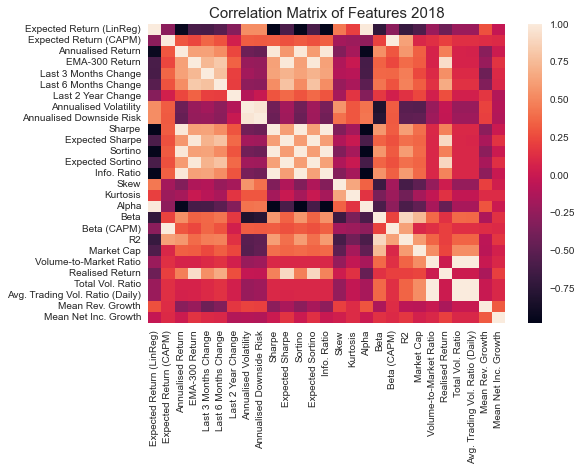

In [175]:
metrics_corr=assets.corr()
sns.heatmap(metrics_corr)
plt.title('Correlation Matrix of Features 2018', fontsize=15)

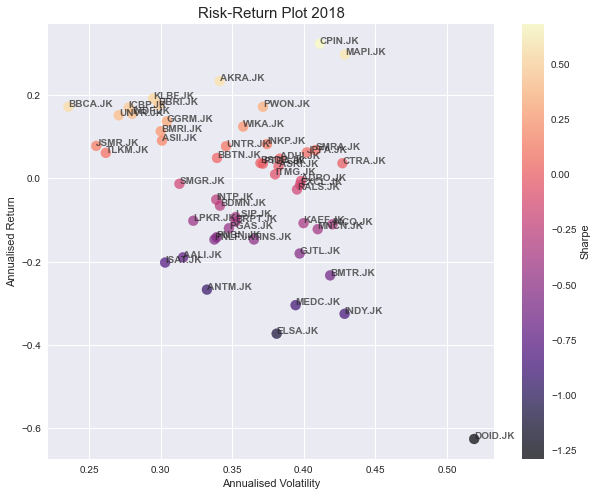

In [176]:
fig, ax = plt.subplots()
Y = 'Annualised Return'
X = 'Annualised Volatility'
C = 'Sharpe'
ax= assets.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
ax.set_title('Risk-Return Plot 2018', fontsize=15)
label_point(assets[X], assets[Y], assets.index.to_series(), ax)

In [177]:
arr_scaled = scaler.fit_transform(assets)
assets_scaled = pd.DataFrame(arr_scaled, columns=assets.columns,index=assets.index)
assets_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
AALI.JK,0.7946,0.2328,0.4594,0.3914,0.4451,0.4044,0.2557,0.2827,0.3553,0.2796,...,0.2888,0.2328,0.2467,0.0179,0.0027,0.3544,0.0027,0.0027,0.2248,0.4582
ADHI.JK,0.4939,0.7242,0.7092,0.4533,0.8852,0.4832,0.1898,0.5211,0.4511,0.6597,...,0.2969,0.7242,0.4653,0.0011,0.1156,0.3842,0.1156,0.1155,0.1908,0.4832
ADRO.JK,0.5760,0.7688,0.6528,0.4726,0.3544,0.5282,0.4552,0.5732,0.5704,0.5912,...,0.2681,0.7688,0.4532,0.0514,0.3660,0.5029,0.3660,0.3660,0.2288,0.4646
AKRA.JK,0.2623,0.4211,0.9055,0.4342,0.7208,0.4903,0.3933,0.3728,0.2987,0.9376,...,0.3000,0.4211,0.3424,0.0159,0.0631,0.3117,0.0631,0.0632,0.3147,0.4889
ANTM.JK,0.9277,0.5111,0.3778,0.3241,0.2403,0.3691,0.0552,0.3415,0.2900,0.1801,...,0.3824,0.5111,0.4514,0.0751,0.2920,0.4288,0.2920,0.2920,0.6600,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.7502,0.6297,0.5046,0.4329,0.4503,0.3918,0.0874,0.4572,0.3052,0.3900,...,0.3152,0.6297,0.4430,0.0117,0.1077,0.4222,0.1077,0.1076,0.2698,0.4357
TLKM.JK,0.3753,0.3855,0.7236,0.5467,0.7261,0.6294,0.3435,0.0923,0.1001,0.6890,...,0.7052,0.3855,0.6228,0.4089,0.6462,0.4657,0.6462,0.6465,0.1844,0.4622
UNTR.JK,0.4161,0.7430,0.7406,0.4558,0.5632,0.5406,0.5579,0.3885,0.3874,0.7041,...,0.4479,0.7430,0.6093,0.0962,0.0218,0.4253,0.0218,0.0218,0.3260,0.4954
UNVR.JK,0.2063,0.4263,0.8188,0.5388,0.5665,0.5250,0.5393,0.1243,0.1238,0.8572,...,0.6697,0.4263,0.6237,0.1916,0.0541,0.4116,0.0541,0.0540,0.1819,0.4854


In [178]:
#sns.pairplot(assets_scaled)

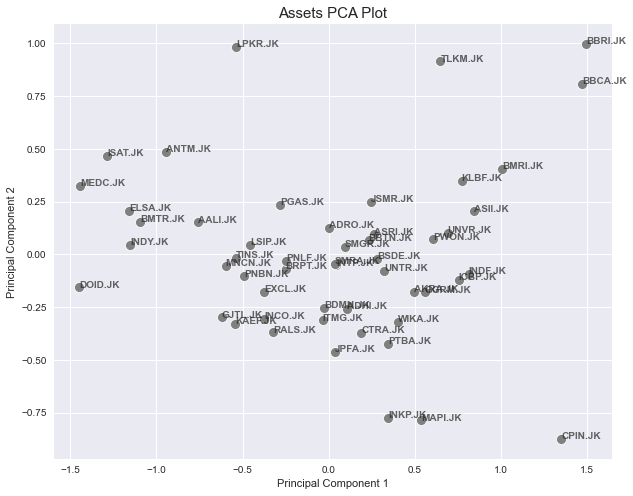

In [266]:
data_plot=getPCA(assets_scaled)
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, s=100, 
                palette='Set1', color='gray')
ax.set_title('Assets PCA Plot', fontsize=15)
label_point(X, Y,
            data_plot.index.to_series(), ax)

In [180]:
cor_target=abs(metrics_corr['Realised Return'])
relevant_features = cor_target[cor_target>0.5]
relevant_index = relevant_features.index

In [181]:
pd.DataFrame(relevant_index)

,0
0,EMA-300 Return
1,Last 3 Months Change
2,Last 6 Months Change
3,Expected Sharpe
4,Expected Sortino
5,Realised Return


## **K-Means Clustering**

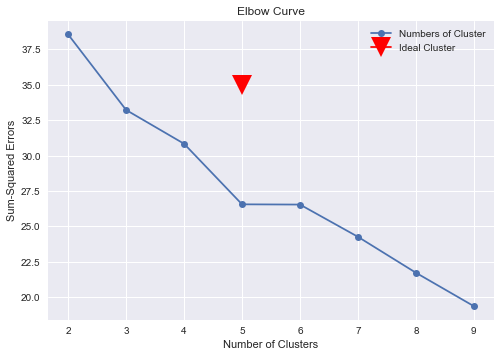

In [284]:
from sklearn.cluster import MiniBatchKMeans


unscaled_X = assets
scaled_X = scaler.fit_transform(unscaled_X)
scaled_X = pd.DataFrame(scaled_X, columns=unscaled_X.columns, index=unscaled_X.index)

cluster_vars = scaled_X

X = cluster_vars.values 

max_cluster = 10

sse_cluster = []

for k in range(2, max_cluster):
    kmeans =MiniBatchKMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse_cluster.append(kmeans.inertia_)
    
plt.plot(range(2, max_cluster), sse_cluster, marker ='o', label='Numbers of Cluster')
plt.plot(5, 35, marker='v', c='r', ms=20, label='Ideal Cluster')
plt.title("Elbow Curve")
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-Squared Errors')
plt.legend()
plt.show()

In [270]:
cluster_vars

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
AALI.JK,0.7946,0.2328,0.4594,0.3914,0.4451,0.4044,0.2557,0.2827,0.3553,0.2796,...,0.2888,0.2328,0.2467,0.0179,0.0027,0.3544,0.0027,0.0027,0.2248,0.4582
ADHI.JK,0.4939,0.7242,0.7092,0.4533,0.8852,0.4832,0.1898,0.5211,0.4511,0.6597,...,0.2969,0.7242,0.4653,0.0011,0.1156,0.3842,0.1156,0.1155,0.1908,0.4832
ADRO.JK,0.5760,0.7688,0.6528,0.4726,0.3544,0.5282,0.4552,0.5732,0.5704,0.5912,...,0.2681,0.7688,0.4532,0.0514,0.3660,0.5029,0.3660,0.3660,0.2288,0.4646
AKRA.JK,0.2623,0.4211,0.9055,0.4342,0.7208,0.4903,0.3933,0.3728,0.2987,0.9376,...,0.3000,0.4211,0.3424,0.0159,0.0631,0.3117,0.0631,0.0632,0.3147,0.4889
ANTM.JK,0.9277,0.5111,0.3778,0.3241,0.2403,0.3691,0.0552,0.3415,0.2900,0.1801,...,0.3824,0.5111,0.4514,0.0751,0.2920,0.4288,0.2920,0.2920,0.6600,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.7502,0.6297,0.5046,0.4329,0.4503,0.3918,0.0874,0.4572,0.3052,0.3900,...,0.3152,0.6297,0.4430,0.0117,0.1077,0.4222,0.1077,0.1076,0.2698,0.4357
TLKM.JK,0.3753,0.3855,0.7236,0.5467,0.7261,0.6294,0.3435,0.0923,0.1001,0.6890,...,0.7052,0.3855,0.6228,0.4089,0.6462,0.4657,0.6462,0.6465,0.1844,0.4622
UNTR.JK,0.4161,0.7430,0.7406,0.4558,0.5632,0.5406,0.5579,0.3885,0.3874,0.7041,...,0.4479,0.7430,0.6093,0.0962,0.0218,0.4253,0.0218,0.0218,0.3260,0.4954
UNVR.JK,0.2063,0.4263,0.8188,0.5388,0.5665,0.5250,0.5393,0.1243,0.1238,0.8572,...,0.6697,0.4263,0.6237,0.1916,0.0541,0.4116,0.0541,0.0540,0.1819,0.4854


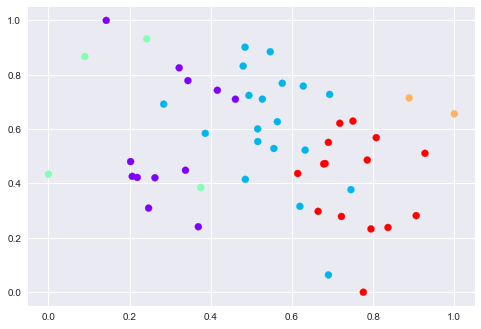

In [271]:
kmeans = MiniBatchKMeans(n_clusters=5, random_state=4567).fit(X)

centroids = kmeans.cluster_centers_

plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

In [272]:
cluster_labels = pd.DataFrame(kmeans.labels_, index= cluster_vars.index, columns=['Cluster Group'])
cluster_labels

,Cluster Group
AALI.JK,4
ADHI.JK,1
ADRO.JK,1
AKRA.JK,0
ANTM.JK,4
...,...
TINS.JK,4
TLKM.JK,2
UNTR.JK,0
UNVR.JK,0


In [273]:
assets_cluster = pd.concat([assets, cluster_labels], axis=1)

In [274]:
assets_cluster_scaled = pd.concat([assets_scaled, cluster_labels], axis=1)

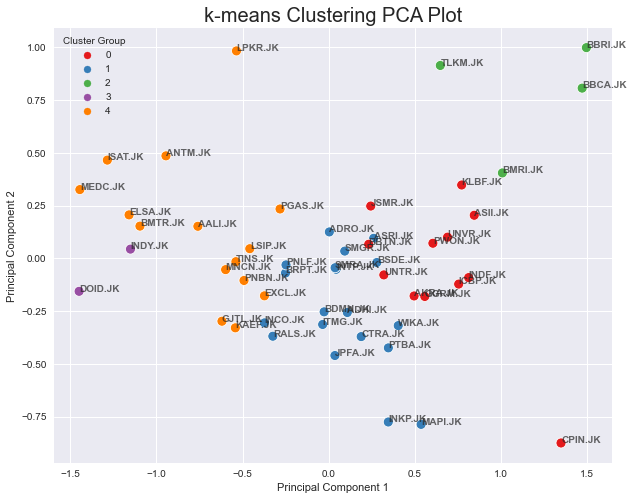

In [275]:
data_plot=getPCA(assets_scaled).join(cluster_labels)
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('k-means Clustering PCA Plot', fontsize=20)
label_point(X, Y,
            data_plot.index.to_series(), ax)

In [276]:
kmeans_mean = assets_cluster.groupby(['Cluster Group']).mean()#.sort_values(by='Ann Returns', ascending=False)
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0089,0.0729,0.1525,0.0499,0.0268,0.0651,0.2308,0.3160,0.1984,0.3389,...,0.3154,0.8002,0.4961,77650000000000.0000,0.0051,-0.1072,0.0051,0.0051,0.1394,0.2217
1,0.0554,0.0738,0.0162,0.0264,0.0380,0.0147,0.0868,0.3779,0.2334,-0.0819,...,0.2264,0.8260,0.4296,26603157894736.8438,0.0058,0.0335,0.0058,0.0058,0.0633,-0.0538
2,-0.0124,0.0748,0.1308,0.1654,0.0803,0.1643,0.2880,0.2739,0.1813,0.3239,...,0.4393,0.8529,0.6067,471540000000000.0000,0.0235,0.0189,0.0235,0.0235,0.0718,0.0628
3,0.1275,0.0755,-0.4752,-0.6614,-0.2700,-0.3599,0.6555,0.4737,0.2932,-1.0738,...,0.1542,0.8713,0.3638,4825000000000.0000,0.0072,-0.5710,0.0072,0.0072,0.9319,-0.0717
4,0.0933,0.0693,-0.1730,-0.5050,-0.1786,-0.2084,-0.3369,0.3650,0.2274,-0.5980,...,0.2071,0.7028,0.3787,17490666666666.6660,0.0061,-0.4705,0.0061,0.0061,0.1642,-0.5500


In [277]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in kmeans_mean.index:
#     sel = assets_cluster[assets_cluster['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [278]:
# kmeans_mean = kmeans_mean.join(actual_return)

In [279]:
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0089,0.0729,0.1525,0.0499,0.0268,0.0651,0.2308,0.3160,0.1984,0.3389,...,0.3154,0.8002,0.4961,77650000000000.0000,0.0051,-0.1072,0.0051,0.0051,0.1394,0.2217
1,0.0554,0.0738,0.0162,0.0264,0.0380,0.0147,0.0868,0.3779,0.2334,-0.0819,...,0.2264,0.8260,0.4296,26603157894736.8438,0.0058,0.0335,0.0058,0.0058,0.0633,-0.0538
2,-0.0124,0.0748,0.1308,0.1654,0.0803,0.1643,0.2880,0.2739,0.1813,0.3239,...,0.4393,0.8529,0.6067,471540000000000.0000,0.0235,0.0189,0.0235,0.0235,0.0718,0.0628
3,0.1275,0.0755,-0.4752,-0.6614,-0.2700,-0.3599,0.6555,0.4737,0.2932,-1.0738,...,0.1542,0.8713,0.3638,4825000000000.0000,0.0072,-0.5710,0.0072,0.0072,0.9319,-0.0717
4,0.0933,0.0693,-0.1730,-0.5050,-0.1786,-0.2084,-0.3369,0.3650,0.2274,-0.5980,...,0.2071,0.7028,0.3787,17490666666666.6660,0.0061,-0.4705,0.0061,0.0061,0.1642,-0.5500


In [280]:
kmeans_scaled = scaler.fit_transform(kmeans_mean)
kmeans_mean_scaled = pd.DataFrame(kmeans_scaled, columns=assets.columns,index=kmeans_mean.index)

In [194]:
kmeans_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.3721,1.0000,0.8733,0.9122,0.9992,0.8961,0.7555,0.8498,0.7926,0.8002,...,0.2819,1.0000,0.5227,0.0602,0.0187,1.0000,0.0187,0.0186,0.1076,0.8650
1,0.0000,0.4382,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,...,1.0000,0.4382,1.0000,1.0000,1.0000,0.9201,1.0000,1.0000,0.0000,0.7678
2,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.5632,0.0000,0.5632,0.5639,1.0000,1.0000
3,0.7704,0.0345,0.4281,0.6888,0.7048,0.7550,0.0201,0.8548,0.7310,0.3610,...,0.0594,0.0345,0.0876,0.0222,0.0000,0.6798,0.0000,0.0000,0.0216,0.0000


Text(0.5, 1.0, "Normalised Means of Clusters' Features")

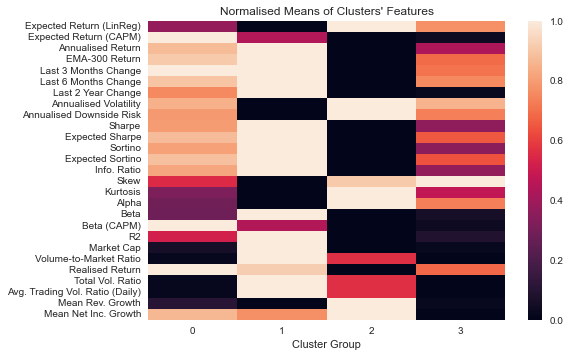

In [195]:
sns.heatmap(kmeans_mean_scaled.T)
plt.title('Normalised Means of Clusters\' Features')

In [196]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean

In [197]:
# data_plot=assets_cluster
# X='EMA-300 Return'
# Y='Annualised Volatility'

# fig, ax = plt.subplots(figsize = [10,8])
# sns.set_style('darkgrid')
# ax = sns.scatterplot(x=X, y=Y, 
#                 data=data_plot, 
#                 hue='Cluster Group', s=100, 
#                 palette='Set1')
# ax.set_title('K-Means Analysis Plot: Expected Returns vs Mean Volatility (Normalised)', fontsize=20)
# label_point(data_plot[X], data_plot[Y],
#             data_plot.index.to_series(), ax)

In [198]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean
picking_param = 'Alpha'
kmeans_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     kmeans_portfolio=kmeans_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [199]:
kmeans_portfolio = cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

## **Agglomerative Clustering**

In [287]:
from sklearn.cluster import AgglomerativeClustering

assets_input = assets_scaled
assets_dist = pd.DataFrame(pairwise_distances(assets_input), index=assets_input.index, columns=assets_input.index).round(4)

assets_agg = assets_dist
assets_agg

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
AALI.JK,0.0000,1.3391,1.3133,1.5881,1.1483,1.8039,1.5937,2.4468,2.8073,1.3333,...,1.4067,1.7310,0.9363,1.0741,1.4113,0.9333,1.7269,1.3498,1.5861,1.5119
ADHI.JK,1.3391,0.0000,0.8700,0.9118,1.6045,1.0228,0.7362,1.9927,2.1030,0.7153,...,0.8952,0.7722,0.8575,0.6524,0.6080,0.8641,1.4836,0.7701,1.1167,0.5113
ADRO.JK,1.3133,0.8700,0.0000,1.2374,1.4470,1.1997,0.8149,1.9633,1.8759,0.7975,...,0.9260,0.7976,1.0590,0.9532,0.8175,0.9913,1.2827,0.8120,1.3066,1.0488
AKRA.JK,1.5881,0.9118,1.2374,0.0000,2.0654,1.2036,1.2318,1.7333,2.1200,0.9183,...,1.1446,0.8524,1.0714,1.0406,1.0154,1.4629,1.4472,0.8389,0.7147,0.7280
ANTM.JK,1.1483,1.6045,1.4470,2.0654,0.0000,1.9947,1.6788,2.6830,2.7614,1.6689,...,1.7937,1.9322,1.4774,1.4438,1.6863,0.9992,1.9062,1.7232,2.0440,1.7989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.9333,0.8641,0.9913,1.4629,0.9992,1.4789,1.1640,2.3704,2.5069,1.1302,...,1.2040,1.3956,0.8419,0.8519,1.0590,0.0000,1.6890,1.1404,1.5091,1.0968
TLKM.JK,1.7269,1.4836,1.2827,1.4472,1.9062,1.1002,1.1566,1.0847,1.2393,1.2839,...,1.4324,1.1399,1.6663,1.3058,1.5688,1.6890,0.0000,1.3915,1.2019,1.3891
UNTR.JK,1.3498,0.7701,0.8120,0.8389,1.7232,0.8493,1.1218,1.7466,2.0235,0.4870,...,0.8902,0.7634,1.1124,0.6054,0.7632,1.1404,1.3915,0.0000,0.8040,0.8610
UNVR.JK,1.5861,1.1167,1.3066,0.7147,2.0440,0.9340,1.3756,1.3152,1.9240,0.8855,...,1.1557,1.0206,1.3099,0.9198,1.2890,1.5091,1.2019,0.8040,0.0000,0.9310


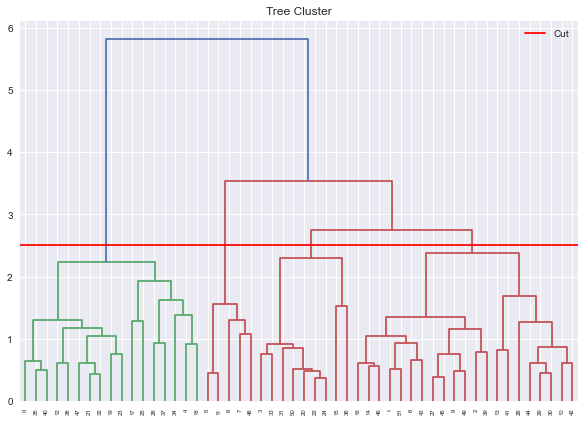

In [290]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10, 7))  
plt.title('Tree Cluster')
plt.axhline(y=2.5, color='r', linestyle='-', label='Cut')
plt.legend()
cond_assets_dist = pdist(assets_input)
dend = dendrogram(linkage(cond_assets_dist, method='ward'))

In [236]:
X_agg = assets_agg.values

In [249]:
agg_clus = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(X_agg)

/Users/rizz/opt/anaconda3/envs/mlstocks/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [250]:
cluster_labels_agg = pd.DataFrame(agg_clus.labels_, index= assets_input.index, columns=['Cluster Group'])
assets_scaled_cluster_agg = pd.concat([assets_input, cluster_labels_agg], axis=1)
assets_scaled_cluster_agg #.sort_values(by='Annualised Returns', ascending=False).head(10)

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth,Cluster Group
AALI.JK,0.7946,0.2328,0.4594,0.3914,0.4451,0.4044,0.2557,0.2827,0.3553,0.2796,...,0.2328,0.2467,0.0179,0.0027,0.3544,0.0027,0.0027,0.2248,0.4582,0
ADHI.JK,0.4939,0.7242,0.7092,0.4533,0.8852,0.4832,0.1898,0.5211,0.4511,0.6597,...,0.7242,0.4653,0.0011,0.1156,0.3842,0.1156,0.1155,0.1908,0.4832,0
ADRO.JK,0.5760,0.7688,0.6528,0.4726,0.3544,0.5282,0.4552,0.5732,0.5704,0.5912,...,0.7688,0.4532,0.0514,0.3660,0.5029,0.3660,0.3660,0.2288,0.4646,0
AKRA.JK,0.2623,0.4211,0.9055,0.4342,0.7208,0.4903,0.3933,0.3728,0.2987,0.9376,...,0.4211,0.3424,0.0159,0.0631,0.3117,0.0631,0.0632,0.3147,0.4889,2
ANTM.JK,0.9277,0.5111,0.3778,0.3241,0.2403,0.3691,0.0552,0.3415,0.2900,0.1801,...,0.5111,0.4514,0.0751,0.2920,0.4288,0.2920,0.2920,0.6600,1.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.7502,0.6297,0.5046,0.4329,0.4503,0.3918,0.0874,0.4572,0.3052,0.3900,...,0.6297,0.4430,0.0117,0.1077,0.4222,0.1077,0.1076,0.2698,0.4357,0
TLKM.JK,0.3753,0.3855,0.7236,0.5467,0.7261,0.6294,0.3435,0.0923,0.1001,0.6890,...,0.3855,0.6228,0.4089,0.6462,0.4657,0.6462,0.6465,0.1844,0.4622,2
UNTR.JK,0.4161,0.7430,0.7406,0.4558,0.5632,0.5406,0.5579,0.3885,0.3874,0.7041,...,0.7430,0.6093,0.0962,0.0218,0.4253,0.0218,0.0218,0.3260,0.4954,0
UNVR.JK,0.2063,0.4263,0.8188,0.5388,0.5665,0.5250,0.5393,0.1243,0.1238,0.8572,...,0.4263,0.6237,0.1916,0.0541,0.4116,0.0541,0.0540,0.1819,0.4854,2


In [251]:
assets_cluster_agg = pd.concat([assets.loc[assets_input.index], cluster_labels_agg], axis=1)
assets_cluster_agg

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth,Cluster Group
AALI.JK,0.1002,0.0654,-0.1895,-0.2999,-0.1791,-0.2420,-0.2083,0.3156,0.2152,-0.7376,...,0.5991,0.3721,16360000000000.0000,0.0004,-0.3042,0.0004,0.0004,0.1028,-0.2691,0
ADHI.JK,0.0454,0.0764,0.0475,-0.1681,0.1186,-0.1343,-0.3458,0.3832,0.2307,0.0111,...,0.8947,0.4574,2920000000000.0000,0.0046,-0.2430,0.0046,0.0046,0.0329,0.2498,0
ADRO.JK,0.0604,0.0774,-0.0060,-0.1270,-0.2405,-0.0729,0.2077,0.3980,0.2501,-0.1237,...,0.9215,0.4527,43180000000000.0000,0.0141,0.0008,0.0141,0.0141,0.1109,-0.1357,0
AKRA.JK,0.0032,0.0696,0.2338,-0.2087,0.0073,-0.1247,0.0786,0.3411,0.2060,0.5587,...,0.7123,0.4095,14760000000000.0000,0.0027,-0.3920,0.0027,0.0026,0.2876,0.3688,2
ANTM.JK,0.1245,0.0716,-0.2669,-0.4429,-0.3177,-0.2903,-0.6263,0.3322,0.2046,-0.9335,...,0.7665,0.4520,62240000000000.0000,0.0113,-0.1514,0.0113,0.0113,0.9975,10.9848,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.0921,0.0743,-0.1466,-0.2116,-0.1756,-0.2593,-0.5592,0.3651,0.2070,-0.5201,...,0.8378,0.4487,11430000000000.0000,0.0043,-0.1649,0.0043,0.0043,0.1952,-0.7367,0
TLKM.JK,0.0238,0.0688,0.0613,0.0305,0.0109,0.0655,-0.0253,0.2616,0.1737,0.0689,...,0.6909,0.5189,329880000000000.0000,0.0246,-0.0757,0.0246,0.0246,0.0197,-0.1857,2
UNTR.JK,0.0312,0.0768,0.0773,-0.1627,-0.0993,-0.0559,0.4217,0.3456,0.2204,0.0986,...,0.9060,0.5136,79170000000000.0000,0.0011,-0.1586,0.0011,0.0011,0.3108,0.5029,0
UNVR.JK,-0.0070,0.0697,0.1516,0.0137,-0.0970,-0.0772,0.3829,0.2706,0.1776,0.4003,...,0.7154,0.5193,155650000000000.0000,0.0023,-0.1869,0.0023,0.0023,0.0145,0.2965,2


<AxesSubplot:>

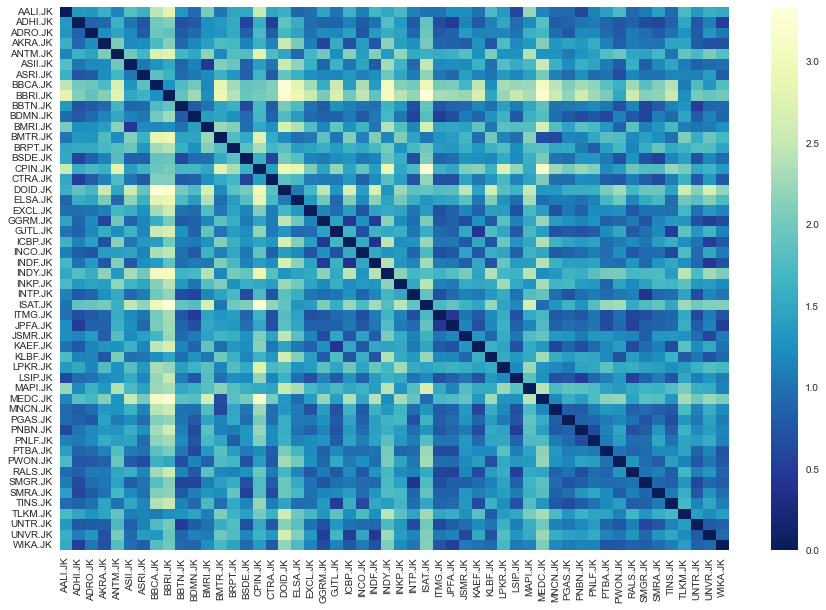

In [252]:
plt.subplots(figsize=(15,10))
sns.heatmap(assets_dist, cmap='YlGnBu_r')

<AxesSubplot:>

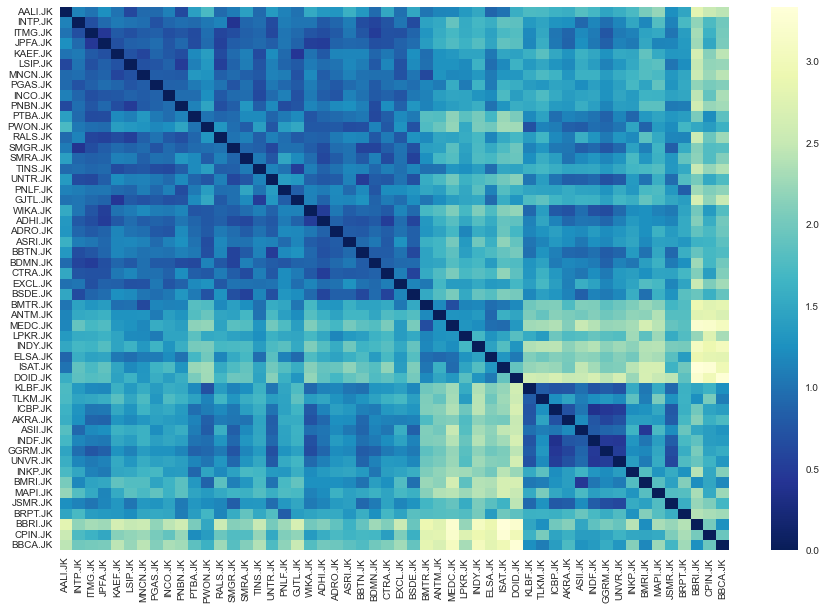

In [253]:
plt.subplots(figsize=(15,10))
sortIx = assets_cluster_agg.sort_values(by='Cluster Group').index
sns.heatmap(assets_dist.loc[sortIx, sortIx], cmap='YlGnBu_r')

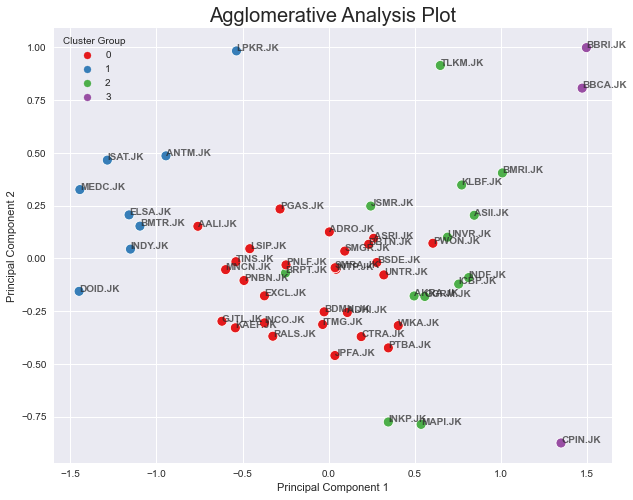

In [291]:
data_plot=getPCA(assets_scaled).join(cluster_labels_agg)
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot', fontsize=20)
label_point(X, Y,
            data_plot.index.to_series(), ax)

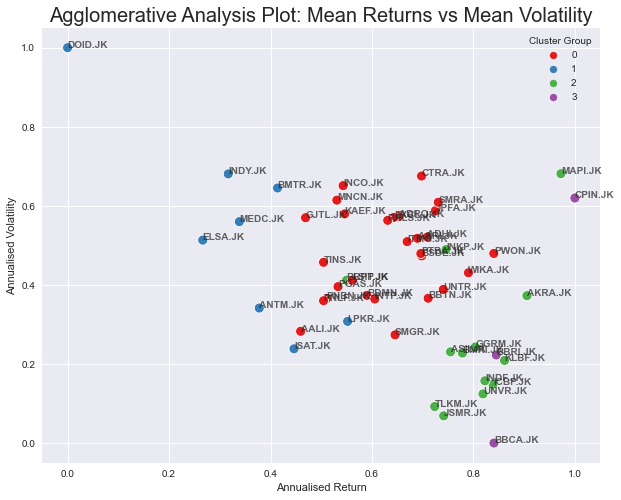

In [255]:
data_plot=assets_scaled_cluster_agg
X= 'Annualised Return'
Y= 'Annualised Volatility'

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: Mean Returns vs Mean Volatility', fontsize=20)
label_point(data_plot[X], data_plot[Y],
            data_plot.index.to_series(), ax)

In [256]:
cluster_agg_mean = assets_cluster_agg.groupby(['Cluster Group']).mean() #.sort_values(by='Alpha', ascending=False)
cluster_agg_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0636,0.0736,-0.0280,-0.1407,-0.0122,-0.0120,-0.0693,0.3716,0.2294,-0.1971,...,0.2323,0.8187,0.4335,21735000000000.0000,0.0050,-0.1718,0.0050,0.0050,0.0872,-0.4973
1,0.1103,0.0696,-0.3038,-0.7724,-0.3046,-0.4228,-0.1362,0.3874,0.2444,-0.8715,...,0.1907,0.7117,0.3623,17105000000000.0000,0.0094,-0.6420,0.0094,0.0094,0.4411,0.5257
2,0.0148,0.0706,0.1276,0.1112,0.0423,0.0387,0.3019,0.3108,0.1959,0.2697,...,0.3122,0.7396,0.4743,113336923076923.0781,0.0076,-0.0014,0.0076,0.0076,0.0950,0.1668
3,-0.0306,0.0773,0.2240,0.5119,0.1246,0.3621,0.3109,0.3150,0.2051,0.5584,...,0.3901,0.9205,0.5823,458876666666666.6875,0.0197,0.3968,0.0197,0.0196,0.0950,0.3487


In [257]:
agg_scaled = scaler.fit_transform(cluster_agg_mean)
agg_mean_scaled = pd.DataFrame(agg_scaled, columns=cluster_agg_mean.columns,index=cluster_agg_mean.index)

In [258]:
agg_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.6685,0.5124,0.5225,0.4919,0.6813,0.5234,0.1497,0.7938,0.6911,0.4716,...,0.2086,0.5124,0.3235,0.0105,0.0000,0.4527,0.0000,0.0000,0.0000,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.2990,0.0000,0.2990,0.2995,1.0000,1.0000
2,0.3222,0.1336,0.8174,0.6880,0.8081,0.5879,0.9800,0.0000,0.0000,0.7981,...,0.6091,0.1336,0.5091,0.2178,0.1811,0.6167,0.1811,0.1814,0.0220,0.6491
3,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0552,0.1904,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0221,0.8270


In [259]:
assets_scaled_cluster_agg.groupby(['Cluster Group']).var()

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0153,0.0337,0.0102,0.0114,0.0322,0.0169,0.0259,0.0122,0.0102,0.0185,...,0.0124,0.0337,0.0229,0.0005,0.0157,0.0209,0.0157,0.0158,0.0051,0.0109
1,0.0104,0.0552,0.0264,0.0226,0.0238,0.0240,0.0744,0.0611,0.0626,0.0167,...,0.0205,0.0552,0.0282,0.0007,0.0350,0.0284,0.0350,0.0350,0.0896,0.0464
2,0.0185,0.0541,0.0103,0.0131,0.0122,0.0058,0.0358,0.0314,0.0311,0.0190,...,0.0579,0.0541,0.0684,0.0170,0.0411,0.0334,0.0411,0.0411,0.0014,0.0004
3,0.0052,0.0875,0.0082,0.0388,0.0041,0.0199,0.0083,0.0986,0.0982,0.0036,...,0.1237,0.0875,0.0326,0.1875,0.2180,0.0523,0.2180,0.2180,0.0001,0.0004


In [260]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in cluster_pca_mean.index:
#     sel = assets_scaled_cluster_pca[assets_scaled_cluster_pca['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [261]:
# actual_return_sort=actual_return.sort_values(by='Actual Return (2020)', ascending=False)
# actual_return_sort

In [262]:
agg_cluster_mean = agg_mean_scaled#.join(actual_return)#.sort_values(by='Alpha', ascending=False)
agg_cluster_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.6685,0.5124,0.5225,0.4919,0.6813,0.5234,0.1497,0.7938,0.6911,0.4716,...,0.2086,0.5124,0.3235,0.0105,0.0000,0.4527,0.0000,0.0000,0.0000,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.2990,0.0000,0.2990,0.2995,1.0000,1.0000
2,0.3222,0.1336,0.8174,0.6880,0.8081,0.5879,0.9800,0.0000,0.0000,0.7981,...,0.6091,0.1336,0.5091,0.2178,0.1811,0.6167,0.1811,0.1814,0.0220,0.6491
3,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0552,0.1904,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0221,0.8270


Text(0.5, 1.0, "Normalised Means of Clusters' Features")

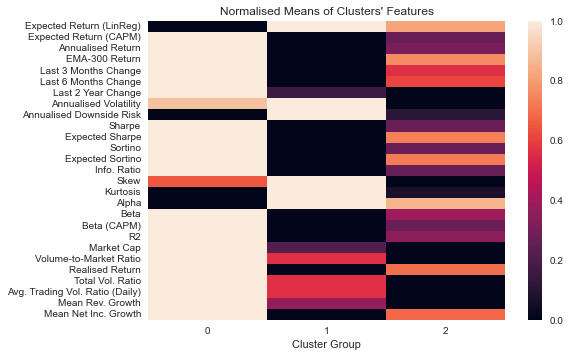

In [217]:
sns.heatmap(agg_cluster_mean.T)
plt.title('Normalised Means of Clusters\' Features')

<AxesSubplot:>

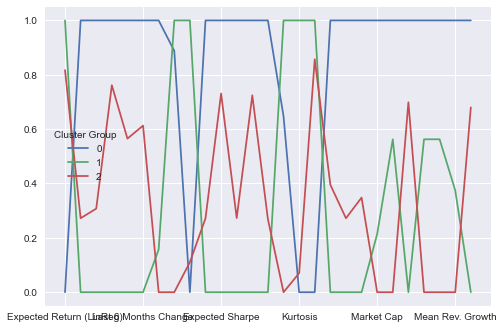

In [218]:
agg_cluster_mean.T.plot()

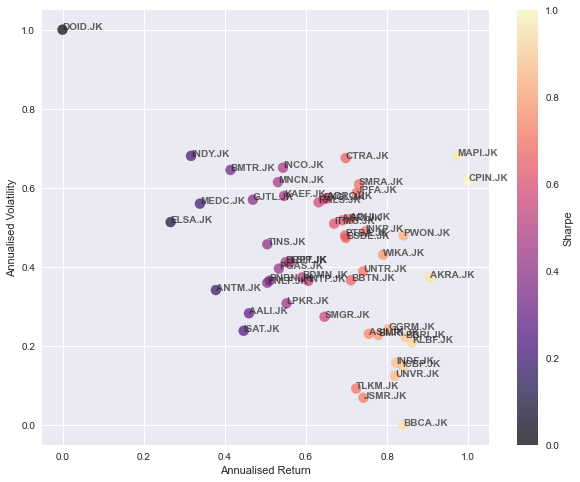

In [219]:
fig, ax = plt.subplots()
data_plot = assets_scaled
X = 'Annualised Return'
Y = 'Annualised Volatility'
C = 'Sharpe'
ax= data_plot.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
label_point(data_plot[X], data_plot[Y], assets.index.to_series(), ax)

In [220]:
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
picking_param = 'Alpha'
agg_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     pca_portfolio=pca_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [221]:
agg_portfolio=cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

# **Hierchical Risk Parity**

In [222]:
import scipy.cluster.hierarchy as sch

class HRPRes:
    def __init__(self, cov, corr, dist, link):
        self.cov = cov
        self.corr = corr
        self.dist = dist
        self.link = link

def HRP(assets_returns):
    rets = assets_returns

    ewm_cov = rets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]

    ewm_corr = rets.ewm(span=300).corr()
    corr = ewm_corr.loc[ewm_corr.index.levels[0][-1]]

    dist=((1-corr)/2.)**.5

    link=sch.linkage(dist, 'single')
    
    return HRPRes(cov=cov, corr=corr, dist=dist, link=link)

In [223]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [224]:
def getHRP(assets_rets):
    if len(assets_rets.columns)<2:
        return pd.Series(1.0, index=assets_rets.columns)
    else:
        HRPres = HRP(assets_rets)
        sortIx=getQuasiDiag(HRPres.link)
        sortIx = HRPres.corr.index[sortIx].tolist()
        return getRecBipart(HRPres.cov, sortIx)

<AxesSubplot:>

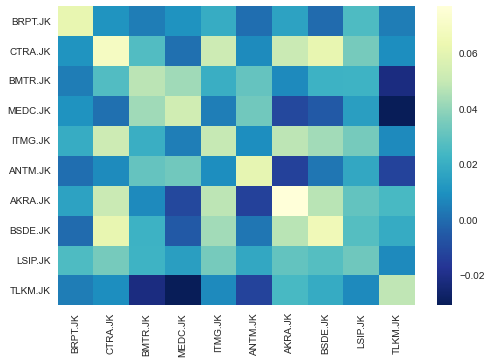

In [344]:
sample_ret = assets_scaled.sample(n=10, axis=0).T
sample_corr = sample_ret.cov()
sns.heatmap(sample_corr, cmap='YlGnBu_r')

/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1047/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


<AxesSubplot:>

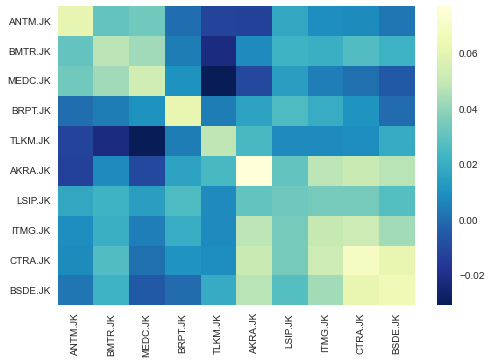

In [345]:
sortIx=getQuasiDiag(HRP(sample_ret).link)
sortIx=HRP(sample_ret).corr.index[sortIx].tolist()
sns.heatmap(sample_corr.loc[sortIx, sortIx], cmap='YlGnBu_r')

No handles with labels found to put in legend.
/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1047/228889477.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = dendrogram(linkage(cond_assets_dist, method='ward'))


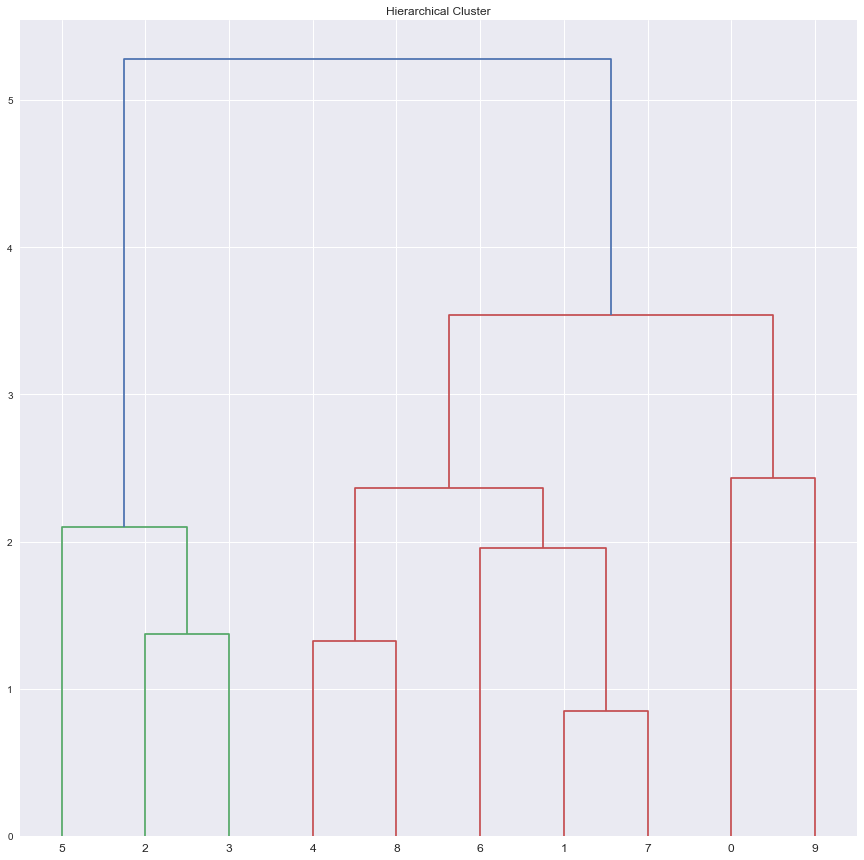

In [351]:
plt.figure(figsize=(15, 15))  
plt.title('Hierarchical Cluster')
plt.legend()
cond_assets_dist = pairwise_distances(sample_ret.T)
dend = dendrogram(linkage(cond_assets_dist, method='ward'))

In [310]:
getHRP(sample_ret)

/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1047/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


TLKM.JK   0.2344
MEDC.JK   0.2025
CTRA.JK   0.0369
ASRI.JK   0.0361
UNTR.JK   0.0292
GGRM.JK   0.0945
LPKR.JK   0.1971
ANTM.JK   0.0736
GJTL.JK   0.0414
PGAS.JK   0.0543
dtype: float64

# **Markowitz Optimisation**

In [ ]:
rng = np.random.default_rng(seed=4567)

class ReturnRes:
    def __init__(self, port, weights):
        self.port = port
        self.weights = weights
        
def monte_carlo_optimise (_assets, num_port):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    num_assets = len(assets_sel.index)
    num_portfolios = num_port
    rand_weights = rng.random(size=(num_portfolios, num_assets))
    _weights = pd.DataFrame((rand_weights.T / rand_weights.sum(axis=1)).T, columns=assets_sel.index).round(3)
    p_ret =mean_ret.dot(_weights.T)*252
    p_real_ret = _weights.dot(_real_ret)
    p_exp_ret = _weights.dot(exp_ret_assets)
    p_vol =_weights.apply(lambda row: np.sqrt(row.T@cov@row), axis=1)*np.sqrt(252)
    p_premium =p_exp_ret - rf_rate
    p_sharpe =p_premium / (p_vol)
    p_weights = _weights.copy()
    p_weights.columns = pd.MultiIndex.from_product([_weights, ['Weights']])
    port_metrics = pd.DataFrame({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 'Volatility':p_vol,
                                    'Sharpe' :p_sharpe})
    portfolios = port_metrics.copy()
    portfolios[p_weights.columns]  = p_weights
    print('Metrics from {}'.format(training_year))
    
    return ReturnRes(port=portfolios, weights=_weights)

def equal_weights_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    num_assets = len(assets_sel.index)
    test_weights_equal = np.ones(num_assets).round(2)*(1/num_assets)
    _weights = pd.Series(test_weights_equal, index=assets_sel.index)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =np.sqrt(_weights.T.dot((cov).dot(_weights)))*np.sqrt(252)
    p_premium =p_exp_ret -rf_rate
    p_sharpe =p_premium / (p_vol)
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 
                              'Volatility':p_vol, 'Sharpe' :p_sharpe, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    print('Metrics from {}'.format(training_year))
    
    return ReturnRes(port=portfolios, weights=_weights)


def HRP_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    _weights = getHRP(ret_assets)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =np.sqrt(_weights.T.dot((cov).dot(_weights)))*np.sqrt(252)
    p_premium =p_exp_ret - rf_rate
    p_sharpe =p_premium / (p_vol)
    #p_weights = _weights.copy()
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 
                              'Volatility':p_vol, 'Sharpe' :p_sharpe, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    #portfolios=portfolios.append(_weights)
    print('Metrics from {}'.format(training_year))

    return ReturnRes(port=portfolios, weights=_weights)

def min_volatility(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx=port['Volatility'].idxmin()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])

def optimal_risk(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx = port['Sharpe'].idxmax()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])


def plot_summarise(portfolios, Y ='Expected Return', X = 'Volatility', plot_opt=True, plot_min=False, plot_alpha=False):
    portfolio = portfolios.port
    plt.subplots(figsize=(10, 8))
    plt.scatter(portfolio[X], portfolio[Y], c= portfolio['Sharpe'],cmap='magma', marker='.', s=10, alpha=0.3)
    plt.colorbar().set_label('Sharpe')
    plt.xlabel(X)
    plt.ylabel(Y)
    
    if plot_opt==True:
        optimal_risky_port=optimal_risk(portfolios).port
        plt.scatter(optimal_risky_port[X], optimal_risky_port[Y], color='g', marker='^', s=200, label = 'Optimal Risky Portfolio - Maximum Sharpe Ratio')
    if plot_min==True:
        min_vol_port =min_volatility(portfolios).port
        plt.scatter(min_vol_port[X], min_vol_port[Y], color='r', marker='^', s=200, label= 'Minimum Volatility Portfolio')
    else:
        pass
    
    plt.legend(labelspacing=0.8, loc='lower left')
    plt.show()
    
def print_port(portfolios):
    portfolio = portfolios.port
    min_vol_port =min_volatility(portfolios).port
    optimal_risky_port=optimal_risk(portfolios).port
    print('-'*10)
    print('Optimally Risky Portfolio')
    print('-'*10)
    print(optimal_risky_port)
    print('-'*10)
    print('-'*10)
    print('Minimal Risk Portfolio')
    print('-'*10)
    print(min_vol_port)
    print('-'*10)

In [229]:
rand_assets = assets.sort_values(by='EMA-300 Return', ascending=False).head(10).sample(n=2)
num_port=5000

Metrics from 2018


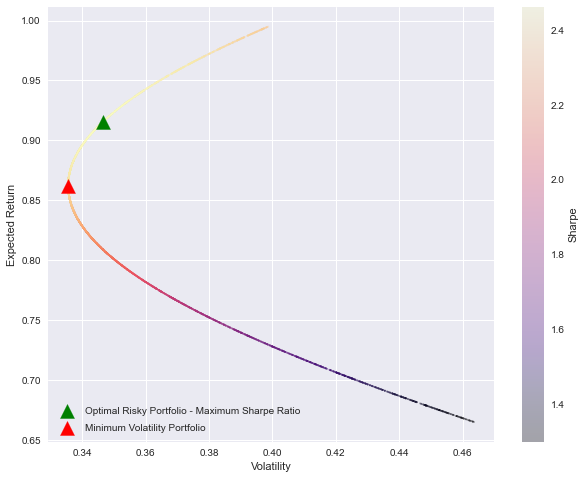

In [230]:
ran_port = monte_carlo_optimise(rand_assets, num_port=5000)
ran_port.port
plot_summarise(ran_port, plot_min=True)

In [231]:
HRP_port(rand_assets).weights

Metrics from 2018


/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1047/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


CPIN.JK   0.5753
INKP.JK   0.4247
dtype: float64

# **Testing 2019**

In [232]:
from scipy.stats import norm

def backtest(portfolios, plots=False, test_year=test_year, num_port=500000, initial_inv=1000000000, weights_equal=False, HRP=False):
    pd.options.display.max_rows = None
     
    if weights_equal==True:
        _port = equal_weights_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights
    elif HRP==True:
        _port = HRP_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights    
    else:
        rand_portfolios = monte_carlo_optimise(portfolios, num_port)
        optimal_risk_port = optimal_risk(rand_portfolios)
        _port = optimal_risk_port
        test_weights = _port.weights.values
        _weights = test_weights
        plot_summarise(rand_portfolios,plot_min=True)
        
    display(_port.port)
    display(_port.weights)
    _port_assets = portfolios
    _num_assets = len(_port_assets)
    test_yr = test_year #Training year + 1 year
    end_yr = f'{int(test_yr)+1}' #Test year + 1 year
    rf_rate = rate_bond.mean()
    
    # Get price data
    port_close_price = close_price_all[_port_assets.index]
    test_close=port_close_price.loc[test_yr:end_yr]
    test_ret = (test_close.iloc[-1] / test_close.iloc[0]) - 1
    test_ret_pct = test_ret
    ret_port_asset=log_rate(test_close).dropna()
    
    # Get unweighted mean and cov
    mean_ret_port=ret_port_asset.mean()
    cov_ret_port =ret_port_asset.cov()
    semicov_ret_port = ret_port_asset[ret_port_asset < 0].cov()
    
    # Calculate returns
    holding_ret_port = test_ret_pct.dot(_weights)
    log_rets = ret_port_asset.dot(_weights)
    port_cum = log_rets.sum()
    log_rets_cum = log_rets.cumsum().ffill()
    max_drawdown = log_rets_cum.min()
    
    # Get monthly and yearly returns
    mon_rets = log_rets.resample('M').sum()
    quarter_rets = log_rets.resample('Q').sum()
    quarter_rets.index = quarter_rets.index.strftime('%m/%Y')
    mon_rets.index = mon_rets.index.strftime('%m/%Y')
    
    # Get weighted mean and cov
    mean_port = mean_ret_port.dot(_weights)
    stdev_port = np.sqrt(_weights.T.dot(cov_ret_port.dot(_weights)))
    semistdev_port = np.sqrt(_weights.T.dot(semicov_ret_port.dot(_weights)))
    
    # Calculate statitics
    volatility = stdev_port
    downside_risk = semistdev_port
    premium = port_cum - rf_rate
    sharpe = premium / (volatility*np.sqrt(252))
    sortino = premium / (downside_risk*np.sqrt(252))
    skew = log_rets.skew()
    kurt = log_rets.kurt()
    
    investment = initial_inv
    mean_investment = (1+mean_port)*investment
    stdev_investment = stdev_port*investment
    conf = 0.05
    conf2 = 0.01
    conf3 = 0.005
    cutoff1 = norm.ppf(conf, mean_port, stdev_port)
    cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
    cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
    vard1_1 = cutoff1 #-(investment - cutoff1)
    vard1_2 = cutoff2 #-(investment - cutoff2)
    vard1_3 = cutoff3 #-(investment - cutoff3)
    hist_vard1_1=log_rets.sort_values(ascending=True).quantile(q=0.05)#*investment
    hist_vard1_2=log_rets.sort_values(ascending=True).quantile(q=0.01)#*investment
    hist_vard1_3=log_rets.sort_values(ascending=True).quantile(q=0.005)#*investment
    res=pd.Series({'Holding Return': holding_ret_port, 'Cumulative Return': port_cum, 'Annualised Volatility': volatility*np.sqrt(252), 'Annualised Downside Risk':downside_risk*np.sqrt(252),
                   'Max Drawdown':max_drawdown,'Ex-Post Sharpe': sharpe, 'Ex-Post Sortino': sortino, 'Skew': skew, 'Kurtosis':kurt,  
                   'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
                   'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
    
    #Plots
    if plots==True:
        fig1, ax1 = plt.subplots(2, 1, figsize=(12,10))
        log_rets.plot(kind='hist', bins=50, title='Portfolio Return Distribution', ax=ax1[0])
        log_rets.plot(kind='kde', title='Portfolio Return Density', ax=ax1[1])
        fig2, ax2 = plt.subplots(1,2,figsize=(12,5))
        mon_rets.plot(kind='barh', ax=ax2[0], title= 'Monthly Returns')
        quarter_rets.plot(kind='barh', ax=ax2[1], title= 'Quarterly Returns')
        fig3, ax3 = plt.subplots(figsize=(12,5))
        df = log_rets_cum
        df.plot(title='Cumulative Rate of Return on Portfolio', ax=ax3)
        plt.fill_between(df.index, 0, df.values, where=df<0, interpolate=True, color='r')
        plt.fill_between(df.index, 0, df.values, where=df>0, interpolate=True, color='g')
        fig4, ax4 = plt.subplots(figsize=(12,5))
        df2 = log_rets.clip(upper=0)
        df2.plot(title='Underwater Plot',ax=ax4, color='r')
        plt.fill_between(df2.index, 0, df2.values, where=df2<0, interpolate=True, color='r')
        plt.ylim(top=0)
        plt.show()
        pd.set_option("display.max_rows", 20)
        
    print('--------------------------------')
    print('--------------------------------') 
    print('Metrics from {} - {}'.format(test_yr,end_yr))
    display(res.apply(lambda x: '%.3f' % x))
    return res

In [ ]:
print('Run Simulation? yes/no')
ask = input()
if ask == 'no':
    raise UserWarning('Early Exit: Continue to Simulation')
else:
    pass

## **Random Assets Portfolio + Equal Weights**

In [ ]:
rand_assets_5 = assets.sample(n=5)

In [ ]:
pd.Series(rand_assets_15.index).to_clipboard()

In [ ]:
rand_5_ew=backtest(rand_assets_5, plots=True, weights_equal=True)

In [ ]:
rand_5_ew.to_clipboard()

In [ ]:
rand_assets_10 = assets.sample(n=10)

In [ ]:
rand_10_ew=backtest(rand_assets_10, weights_equal=True)

In [ ]:
rand_assets_15 = assets.sample(n=15)

In [ ]:
rand_15_ew=backtest(rand_assets_15, weights_equal=True)

In [ ]:
rand_15_ew.to_clipboard()

## **Random Assets Portfolio + Optimised**

In [ ]:
rand_5_mvo=backtest(rand_assets_5)

In [ ]:
rand_5_mvo.to_clipboard()

In [ ]:
rand_10_mvo=backtest(rand_assets_10)

In [ ]:
rand_10_mvo.to_clipboard()

In [ ]:
rand_15_mvo=backtest(rand_assets_15)

In [ ]:
rand_15_mvo.to_clipboard()

## **Random Assets Portfolio + HRP**

In [ ]:
rand_5_hrp=backtest(rand_assets_5, HRP=True)

In [ ]:
rand_10_hrp=backtest(rand_assets_10, HRP=True)

In [ ]:
rand_15_hrp=backtest(rand_assets_15, HRP=True)

In [ ]:
rand_15_hrp.to_clipboard()

## **Clustered Assets Portfolio + Equal Weights** 

In [ ]:
#backtest(kmeans_portfolio, weights_equal=True)
cluster_method= assets_cluster
cluster_mean = kmeans_mean
cluster_kmeans_ew = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_kmeans_ew[cluster]=backtest(portf, weights_equal=True)

In [ ]:
cluster_kmeans_ew.to_clipboard()

In [ ]:
# backtest(agg_portfolio, weights_equal=True)
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
cluster_agg_ew = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_agg_ew[cluster]=backtest(portf, weights_equal=True)

In [ ]:
cluster_agg_ew.to_clipboard()

## **Clustered Assets Portfolio + Optimised** 

In [ ]:
# backtest(kmeans_portfolio)
cluster_method= assets_cluster
cluster_mean = kmeans_mean
cluster_kmeans_mvo = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_kmeans_mvo[cluster]=backtest(portf, num_port=500000)

In [ ]:
# backtest(agg_portfolio)
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
cluster_agg_mvo = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_agg_mvo[cluster]=backtest(portf, num_port=500000)

In [ ]:
cluster_agg_mvo.to_clipboard()

## **Clustered Assets Portfolio + HRP** 

In [ ]:
# backtest(kmeans_portfolio, HRP=True)
cluster_method= assets_cluster
cluster_mean = kmeans_mean
cluster_kmeans_hrp = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_kmeans_hrp[cluster]=backtest(portf, HRP=True)

In [ ]:
# backtest(pca_portfolio, HRP=True)
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
cluster_agg_hrp = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_agg_hrp[cluster]=backtest(portf, HRP=True)

In [ ]:
cluster_agg_hrp.to_clipboard()

## **Market Portfolio**

In [ ]:
market_test = df2['Close'][test_year:f'{int(test_year)+1}']
market_hold_ret = (market_test.iloc[-1] / market_test[0]) -1 
market_log_ret = log_rate(market_test).cumsum().ffill()
print('Market Holding Return')
market_hold_ret

In [ ]:
# market_log_ret

In [ ]:
market_log_ret.plot(title='Market Cumulative Rate of Return 2019 - 2020', figsize=(12,5))

In [ ]:
df5 = market_log_ret
df5.plot(title='Market Cumulative Return 2019 - 2020', figsize=(12,5))
plt.fill_between(df5.index, 0, df5.values, where=df5<0, interpolate=True, color='r')
plt.fill_between(df5.index, 0, df5.values, where=df5>0, interpolate=True, color='g')

In [ ]:
print('Market Cumulative Return')
market_log_ret.iloc[-1]

In [ ]:
mean_port = market_log_ret.mean()
stdev_port = market_log_ret.std()
max_drawdown = market_log_ret.min()
volatility = stdev_port*np.sqrt(252)
sharpe = (market_hold_ret) / (volatility)
skew = market_log_ret.skew(axis=0)
kurt = market_log_ret.kurt(axis=0)
conf = 0.05
conf2 = 0.01
conf3 = 0.005
cutoff1 = norm.ppf(conf, mean_port, stdev_port)
cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
vard1_1 = cutoff1 #-(investment - cutoff1)
vard1_2 = cutoff2 #-(investment - cutoff2)
vard1_3 = cutoff3 #-(investment - cutoff3)
hist_vard1_1=market_log_ret.sort_values(ascending=True).quantile(q=0.05)#*investment
hist_vard1_2=market_log_ret.sort_values(ascending=True).quantile(q=0.01)#*investment
hist_vard1_3=market_log_ret.sort_values(ascending=True).quantile(q=0.005)#*investment
res=pd.Series({'Holding Return': market_hold_ret, 'Cumulative Return': market_log_ret.iloc[-1], 'Annualised Volatility': volatility, 'Max Drawdown':max_drawdown, 'Sharpe': sharpe, 'Skew': skew, 'Kurtosis':kurt,  
               'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
               'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
display(res.apply(lambda x: '%.3f' % x))

market_metrics= res


In [ ]:
market_metrics.to_clipboard()